
#***ML Project 1***#
##**Mighty Excavators**##
###***Research Scartch code***###

Lior Ver 8.4.3 || 13 JUL-2024

#**Installations & Imports**

In [257]:
import gdown
import numpy as np
import pandas as pd
import re

import seaborn as sns  # seaborn is used for pairplot
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

import os
from pathlib import Path
import zipfile

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import make_regression
from sklearn.impute import SimpleImputer


le = LabelEncoder()


#**Utilities & Functions**#

##**File Saving Functions**##

In [258]:
# Function to stitch a simple list to a DataFrame
def stich_df_to_list(df, list, list_name='y'):

    # Print lengths of list and df
    print(f"Length of {list_name} list is: {len(list)}")
    print(f"Length of df is: {len(df)}")

    # Check if the number of rows in df and the list are the same
    if len(list) != len(df):
        raise ValueError("The number of rows in list and df must be the same")

    # Create a Series with the predicted Sale_Price
    list_series = pd.Series(list, index=df.index, name=list_name)

    # Combine the original DataFrame with the new Series
    out_df = pd.concat([list_series, df], axis=1)

    return out_df

In [259]:
def save_df_as_file (df, file_name='backup'):
  # Saving df with the given name
  # to: CSV
  #     ZIP
  #     xslx - currently on hold
  # File name will be as inputed + YYYY-MM_DD HH:MM

  ### Preparations:

  # Get current date and time
  now =  datetime.now()
  # now += timedelta(hours=3)
  timestamp1 = now.strftime("%Y-%m-%d_%H%M")

  # Create a file name
  csv_file_path   = file_name + '-' + timestamp1 + '.csv'
  zip_file_path   = file_name + '-' + timestamp1 + '.zip'

  # Handle the input df
  # Reset the index and rename the new column in our case to 'Sales_ID'
  df = df.reset_index().rename(columns={'index': 'Sales_ID'})

  ### Deleting an old version of the file, although, although a bit rare.

  # Check if the file exists before attempting to delete it
  if os.path.exists(csv_file_path):
    os.remove(csv_file_path)
    print(f"File {csv_file_path} deleted successfully.")

  if os.path.exists(zip_file_path):
    os.remove(zip_file_path)
    print(f"File {zip_file_path} deleted successfully.")

   # if os.path.exists(excel_file_path):
   #   os.remove(excel_file_path)
   #   print(f"File {excel_file_path} deleted successfully.")
   # else:
   #   print(f"File {excel_file_path} does not exist.")

  # Save the input DataFrame to a CSV file
  df.to_csv(csv_file_path, index=False)
  print(f"DataFrame saved to {csv_file_path}")

  # Compress the saved CSV file into a ZIP file , and save it
  with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(csv_file_path, os.path.basename(csv_file_path))

  print(f"DataFrame saved to {zip_file_path}")


##**Plot Functions**##

In [260]:
# Function to create a bar plot for value occurrences in a column
def plot_value_counts(df, column, ax):
    value_counts = df[column].value_counts()
    sns.barplot(x=value_counts.index, y=value_counts.values, ax=ax)
    ax.set_title(f'Value Counts for {column}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Count')
    for label in ax.get_xticklabels():
        label.set_rotation(90)

In [261]:
# Columns List to Plot
# columns_list = df4.columns.tolist()

# Function to Create multi column plots for columns list
def multi_col_stick_plot (df, columns_list=None):

  # If columns_list is not provided, use all columns
  if columns_list is None:
     columns_list = df.columns

  # Number of columns to plot
  num_columns = len(columns_list)
  num_rows = (num_columns // 5) + 1

  # Create a figure and axes for the subplots
  fig, axes = plt.subplots(nrows=num_rows, ncols=5, figsize=(20, 5 * num_rows))

  # Flatten the axes array for easy iteration
  axes = axes.flatten()

  # Iterate through the columns and create a plot for each
  for i, col in enumerate(columns_list):
    if col in df.columns:
       plot_value_counts(df, col, axes[i])
    else:
       print(f"Column '{col}' does not exist in the DataFrame.")
       axes[i].axis('off')  # Turn off the unused subplot

  # Hide any unused subplots
  for j in range(i + 1, len(axes)):
    axes[j].axis('off')

  # Adjust layout and show the plots
  plt.tight_layout()
  plt.show()


In [262]:
def explore_columns (df, columns_list, mode, df_other):

  value_counts = df[columns_list].value_counts(dropna=False).sort_values(ascending=False)

  print(value_counts)
  multi_col_stick_plot(df, columns_list)

In [263]:
def plot_pair_histograms(df, col1, col2, mode, df_other):

      print(f"\nPlot pair histograms for comparing values")
      print(f"Operation mode: {mode}")

      # Plot histograms
      plt.figure(figsize=(14, 6))

      # Histogram 1 for col1
      plt.subplot(1, 2, 1)
      df['Machine_Hours_Current_Meter'].plot(kind='hist', bins=10, color='blue', edgecolor='black')
      plt.title('Histogram of Machine_Hours_Current_Meter')
      plt.xlabel('Machine_Hours_Current_Meter')
      plt.ylabel('Frequency')

      # Histogram 2 for col2
      plt.subplot(1, 2, 2)
      df['Machine_Hours_Current_Meter_Log'].plot(kind='hist', bins=10, color='green', edgecolor='black')
      plt.title('Histogram of Machine_Hours_Current_Meter_Log')
      plt.xlabel('Machine_Hours_Current_Meter_Log')
      plt.ylabel('Frequency')

      plt.tight_layout()
      plt.show()

In [264]:
def corr_matrix_plot (df, columns_list=None):
  """
    Calculate and plot the correlation matrix for specified columns.
    If columns_list is None, use all columns in the DataFrame.

    Parameters:
    df (DataFrame): The input DataFrame.
    columns_list (list, optional): List of columns to include in the correlation matrix. Defaults to None.
  """
  # If columns_list is not provided, use all columns
  if columns_list is None:
    columns_list = df.columns

  # Calculate the correlation matrix for the specified NUMERIC columns
  columns_list = df.select_dtypes(include='number').columns

  corr_matrix = df[columns_list].corr()


  # Display the correlation matrix
  # print("\nCorrelation Matrix:")
  # print(corr_matrix)

  # Create a heatmap of the correlation matrix
  plt.figure(figsize=(14, 14))
  sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=1)
  plt.title('Feature Correlation Matrix')
  plt.show()

#**Download Files**#

In [265]:
# Function to download ML projects file from URL's
# 1. Get files URL
# 2. Download files to loacl storage

def download_from_gdrive(url, filename):

    # Extract the file ID from the URL
    file_id = url.split('/')[-2]
    download_url = f"https://drive.google.com/uc?id={file_id}"

    # Download the file
    if Path(filename).exists():
        print(f"File '{filename}' already exists. Skipping download.")
    else:
        gdown.download(download_url, filename, quiet=False)
        print(f"File downloaded as: {filename}")

#-----------------------------------------------------------------------------------------------#

# File URLs to Download
train_url = 'https://drive.google.com/file/d/1guqSpDv1Q7ZZjSbXMYGbrTvGns0VCyU5/view?usp=drive_link'
valid_url = 'https://drive.google.com/file/d/1j7x8xhMimKbvW62D-XeDfuRyj9ia636q/view?usp=drive_link'

# Downloading Files
download_from_gdrive(train_url, 'train.csv')
download_from_gdrive(valid_url, 'valid.csv')

File 'train.csv' already exists. Skipping download.
File 'valid.csv' already exists. Skipping download.


#**Initialayzing Train-Test & validationation Dataframes**#

In [266]:
# Function that get a CSV file name
# 1. Read it from local storage
# 2. Return a Data Frame

def init_df (csv_file):
  print(f"\nReading CSV file: {csv_file}...")

  df = pd.read_csv(csv_file)
  num_rows = len(df)
  print("Number of rows in: {csv_file} : {num_rows}")
  return (df)

##**Columns Renaming**

In [267]:
def rename_columns(df, mode=None, df_other=None):
    print (f"\nColumns Renaimg for consistent naming convenssion...")

    df.rename(columns={'SalesID'                 : 'Sales_ID',
                       'SalePrice'               : 'Sale_Price',
                       'MachineID'               : 'Machine_ID',
                       'ModelID'                 : 'Model_ID',
                       'datasource'              : 'Data_Source',
                       'auctioneerID'            : 'Auctioneer_ID',
                       'YearMade'                : 'Year_Made',
                       'MachineHoursCurrentMeter': 'Machine_Hours_Current_Meter',
                       'UsageBand'               : 'Usage_Band',
                       'saledate'                : 'Sale_Date',
                       'fiModelDesc'             : 'Fi_Model_Desc',
                       'fiBaseModel'             : 'Fi_Base_Model',
                       'fiSecondaryDesc'         : 'Fi_Secondary_Desc',
                       'fiModelSeries'           : 'Fi_Model_Series',
                       'fiModelDescriptor'       : 'Fi_Model_Descriptor',
                       'ProductSize'             : 'Product_Size',
                       'fiProductClassDesc'      : 'Fi_Product_Class_Desc',
                       'state'                   : 'State',
                       'ProductGroup'            : 'Product_Group',
                       'ProductGroupDesc'        : 'Product_Group_Desc',
                       'Drive_System'            : 'Drive_System',
                       'Enclosure'               : 'Enclosure',
                       'Grouser_Tracks'          : 'Grouser_Tracks',
                       'Forks'                   : 'Forks',
                       'Pad_Type'                : 'Pad_Type',
                       'Ride_Control'            : 'Ride_Control',
                       'Stick'                   : 'Stick',
                       'Transmission'            : 'Transmission',
                       'Turbocharged'            : 'Turbo_Charged',
                       'Blade_Extension'         : 'Blade_Extension',
                       'Blade_Width'             : 'Blade_Width',
                       'Enclosure_Type'          : 'Enclosure_Type',
                       'Engine_Horsepower'       : 'Engine_Horsepower',
                       'Hydraulics'              : 'Hydraulics',
                       'Pushblock'               : 'Push_Block',
                       'Ripper'                  : 'Ripper',
                       'Scarifier'               : 'Scarifier',
                       'Tip_Control'             : 'Tip_Control',
                       'Tire_Size'               : 'Tire_Size',
                       'Coupler'                 : 'Coupler',
                       'Coupler_System'          : 'Coupler_System',
                       'Grouser_Tracks'          : 'Grouser_Tracks',
                       'Hydraulics_Flow'         : 'Hydraulics_Flow',
                       'Track_Type'              : 'Track_Type',
                       'Undercarriage_Pad_Width' : 'Undercarriage_Pad_Width',
                       'Stick_Length'            : 'Stick_Length',
                       'Thumb'                   : 'Thumb',
                       'Pattern_Changer'         : 'Pattern_Changer',
                       'Grouser_Type'            : 'Grouser_Type',
                       'Backhoe_Mounting'        : 'Backhoe_Mounting',
                       'Blade_Type'              : 'Blade_Type',
                       'Travel_Controls'         : 'Travel_Controls',
                       'Differential_Type'       : 'Differential_Type',
                       'Steering_Controls'       : 'Steering_Controls',
                    }, inplace=True)
    return (df)



#**Data Cleansing & Conversion**


##**Delete Rows with `Zero-Value` Keys**##

In [268]:
def delete_zero_keys_rows(df, columns, mode=None, df_other=None):

    # Delete rows where any value in the specified columns is 0
    print("\nDelete rows with Zero-Value keys")
    print(f"Operation mode: {mode}")
    print(f"Number of rows in input df: {len(df)}")

    # Filter out rows where any of the specified columns have a value of 0
    condition = (df[columns[0]] != 0)
    for col in columns[1:]:
        condition &= (df[col] != 0)

    df_out = df[condition]

    print(f"Number of rows in output df: {len(df_out)}")
    return df_out

##**Remove Columns - Basic**##

- **Remove Columns with no Business Value**
- **Remove One of Two Paired Identical Meaning Features**  
IE `Fi_Base_Model` has equal meaning to `Fi_Model_Desc` - need only one.

In [269]:
def drop_columns (df, columns_list, mode, df_other):


  print("\nDropping Selected Columns")
  print(f"Operation mode: {mode}")

  print(f"Number of columns in input df: {len(df.columns)}\n")

  df_out = df.copy()

  for col in columns_list:
    df_out = df_out.drop([col], axis=1)
    print (f"Column: '{col}' dropped")
  return (df_out)

##**Dates handling**##
- Convert `Sale Date` to `Date`
- Convert `Year_Made` to number
- Remove  `Year_Made` bad rows.
- `Dates` Feature Engineering



In [270]:
def explore_year_made (df, mode, df_other):
  print (f"\nExplore year made")
  print (f"Operation mode: {mode}")

  # Step 1:
  # Count null values in the 'Sale_Date' column
  # num_nulls_saledate = df2['Sale_Date'].isnull().sum()
  # print(f"Number of null values in num_nulls_saledate: {num_nulls_saledate}")


  # Instruct displaying all pandas DF Values
  # pd.set_option('display.max_rows', None)
  pd.reset_option('display.max_rows', 20)

  # Compute value counts for 'year_made'
  year_made_value_counts = df['Year_Made'].value_counts().sort_index()
  print("\nyear_made_value_counts: {year_made_value_counts}\n")

  # Plotting with Matplotlib
  plt.figure(figsize=(12, 7))
  ax = year_made_value_counts.plot(kind='bar')
  plt.title('Value Counts of Year Made')
  plt.xlabel('Year Made')
  plt.ylabel('Count')

  # Customize x-axis label intervals and rotation
  plt.xticks(rotation=90)  # Rotate x labels by 90 degrees

  # Show the plot
  plt.show()

  #---------------------------------------------------------------------------#

  # Compute value counts for 'Sale_Date'
  # sale_date_value_counts = df['Sale_Date'].value_counts().sort_index()
  # print(sale_date_value_counts)

  # Plotting with Matplotlib
  # plt.figure(figsize=(12, 7))
  # ax = sale_date_value_counts.plot(kind='bar')
  # plt.title('Value Counts of Sale Dates')
  # plt.xlabel('Sale Dates')
  # plt.ylabel('Count')

  # Customize x-axis label intervals and rotation
  # plt.xticks(rotation=90)  # Rotate x labels by 90 degrees

  # Show the plot
  # plt.show()

  #---------------------------------------------------------------------------#


In [271]:
  def convert_date_cols(df, mode, df_other):
    print("\nConvert Date Columns")
    print (f"Operation mode: {mode}")

    # Step 1: Converting Sale_Date to datetime
    try:
        df['Sale_Date'] = pd.to_datetime(df['Sale_Date'], errors='coerce')
        print("Converted 'Sale_Date' to datetime.")
    except Exception as e:
        print(f"Error converting 'Sale_Date' to datetime: {e}")

    # Step 2: Converting Year_Made to numeric
    try:
        df['Year_Made'] = pd.to_numeric(df['Year_Made'], errors='coerce')

        print("Converted 'Year_Made' to numeric.")
    except Exception as e:
        print(f"Error converting 'Year_Made' to numeric: {e}")

    return df

In [272]:
def handle_year_made(df, threshold=25, mode='train', df_other=None):
    print("\nHandle Year Made Column")
    print(f"Operation mode: {mode}")

    initial_rows = len(df)
    print(f"Input Dataset Rows: {initial_rows}")

    # Step 1: Replace 1000 and old years to 1950
    df['Year_Made'] = df['Year_Made'].fillna(1950)
    df['Year_Made'] = df['Year_Made'].mask(df['Year_Made'] < 1950, 1950)
    # df['Year_Made'] = df['Year_Made'].replace(1000, 1950)

    return df

In [273]:
def handle_year_made_old(df, threshold=25, mode=None, df_other=None):

    print ("\nHandle Year Made Column")
    print (f"Operation mode: {mode}")

    initial_rows = len(df)
    removed_rows = 0

    print (f"Input Dataset Rows: {initial_rows}")

    print ("1. Handle incorrect Year_Made rows...")
    print ("Currently ignored because they appear and needed in the VALIDATION STAGE at valid.csv")

    # Step 1: remove rows where Year_Made = 1000
    print("\nRemoving rows where Year_Made is 1000...")
    df = df[df['Year_Made'] != 1000]

    # removed_rows = initial_rows - len(df)
    # print(f"Removed {removed_rows} rows where Year_Made was 1000.")


    # Step 2: Create a boolean mask for values that occur less than the threshold before removing out
    print(f"\nGroping together as -1 Year_Made values that occur less than {threshold} times...")

    year_made_value_counts = df['Year_Made'].value_counts()
    mask = df['Year_Made'].isin(year_made_value_counts[year_made_value_counts < threshold].index)

    # Step 3: Filter the DataFrame using the mask
    df = df[mask]
    final_rows = len(df)
    return df

    filtered_out_rows = initial_rows - final_rows - removed_rows
    print(f"Filtered out {filtered_out_rows} rows where Year_Made values occur less than {threshold} times.")
    print(f"Number of rows after cleaning: {final_rows}")

    return df

In [274]:
def handle_year_made_old2(df, threshold=25, mode='train', df_other=None):
    print("\nHandle Year Made Column")
    print(f"Operation mode: {mode}")

    initial_rows = len(df)
    print(f"Input Dataset Rows: {initial_rows}")

    # Step 1: Replace year 1000 with NaN
    df['Year_Made'] = df['Year_Made'].fillna(1000)
    df['Year_Made'] = df['Year_Made'].replace(1000, np.nan)

    # Step 2: Replacing year 1000 with the mean year across Model_ID group
    if mode == 'train': # Replace across group
        year_made_means = df.groupby('Model_ID')['Year_Made'].mean().round()
        overall_mean = df['Year_Made'].mean().round()
        df['Year_Made'] = df.groupby('Model_ID')['Year_Made'].transform(lambda x: x.fillna(year_made_means.get(x.name, overall_mean)))

    elif mode in ['validation', 'test']: # Look at other train df
        if df_other is None:
            raise ValueError("df_other must be provided in validation or test mode")

        other_year_made_means = df_other.groupby('Model_ID')['Year_Made'].mean().round()
        global_mean = df_other['Year_Made'].mean().round()

        def impute_year(row):
            if pd.isna(row['Year_Made']):
                return other_year_made_means.get(row['Model_ID'], global_mean)
            return row['Year_Made']

        df['Year_Made'] = df.apply(impute_year, axis=1)

    else:
        raise ValueError("Invalid mode. Must be 'train', 'validation', or 'test'.")

    # Final step: replace any remaining NaNs with a default value and convert to int
    default_year = df['Year_Made'].min() if df['Year_Made'].notna().any() else 1990  # or any other appropriate default
    df['Year_Made'] = df['Year_Made'].fillna(default_year).round().astype(int)

    return df

### `Dates` Feature Engineering

In [275]:
import pandas as pd
import numpy as np

def create_date_features(df, mode, df_other):
    print("\nCreate Date Features")
    print(f"Operation mode: {mode}")

    # Step 5: Feature Engineering - Calculating Machine_Age
    df['Machine_Age_Years'] = (df['Sale_Date'].dt.year - df['Year_Made']).fillna(-1).astype(int)

    # Step 6: Feature Engineering for Sale_Date
    # Handle Sale_Date_YYYYMM
    df['Sale_Date_YYYYMM'] = df['Sale_Date'].dt.strftime('%Y%m')
    df['Sale_Date_YYYYMM'] = pd.to_numeric(df['Sale_Date_YYYYMM'], errors='coerce').fillna(0).astype(int)

    # Handle other date components
    df['Sale_Date_YYYY'] = df['Sale_Date'].dt.year.fillna(-1).astype(int)
    df['Sale_Date_MM'] = df['Sale_Date'].dt.month.fillna(-1).astype(int)
    df['Sale_Date_DD'] = df['Sale_Date'].dt.day.fillna(-1).astype(int)

    # Print data types and null counts for verification
    print("\nColumn data types and null counts:")
    for col in ['Machine_Age_Years', 'Sale_Date_YYYYMM', 'Sale_Date_YYYY', 'Sale_Date_MM', 'Sale_Date_DD']:
        print(f"{col}: {df[col].dtype}, Null count: {df[col].isnull().sum()}")

    return df

# Example usage:
# df = create_date_features(df, mode='train', df_other=None)

In [276]:
def create_date_features_old (df, mode, df_other):

  print("\nCreate Date Features")
  print("Operation mode: {mode}")


  # Step 5: Feature Engineering - Calculating Machine_Age
  df.loc[:, 'Machine_Age_Years'] = df['Sale_Date'].dt.year - df['Year_Made']
  df['Machine_Age_Years'] = df['Machine_Age_Years'].astype(int)


  #if mode == 'train':
    # Replace negative Machine_Age_Years with the mean value for their respective Model_ID
  #  model_mean_ages = df.groupby('Model_ID')['Machine_Age_Years'].transform('mean').round().astype(int)   # train
  #  df.loc[df['Machine_Age_Years'] < 0, 'Machine_Age_Years'] = model_mean_ages

  #else: #mode is test or validation
  #  model_mean_ages = df.groupby('Model_ID')['Machine_Age_Years'].transform('mean').round().astype(int) # test & validationation
   # df.loc[df['Machine_Age_Years'] < 0, 'Machine_Age_Years'] = model_mean_ages


  # Step 6: Feature Engineering for Sale_Date

  df.loc[:, 'Sale_Date_YYYYMM'] = df['Sale_Date'].dt.strftime('%Y%m')
  df.loc[:, 'Sale_Date_YYYYMM'] = df['Sale_Date_YYYYMM'].astype(int)
  #df.loc[:, 'Sale_Date_YYYYMM'] = pd.to_numeric(df['Sale_Date_YYYYMM'], errors='coerce').fillna(-1).astype(int)

  df.loc[:, 'Sale_Date_YYYY']   = df['Sale_Date'].dt.year
  df.loc[:, 'Sale_Date_YYYY']   = df['Sale_Date_YYYY'].astype(int)

  df.loc[:, 'Sale_Date_MM']     = df['Sale_Date'].dt.month
  df.loc[:, 'Sale_Date_MM']     = df['Sale_Date_MM'].astype(int)

  df.loc[:, 'Sale_Date_DD']     = df['Sale_Date'].dt.day
  df.loc[:, 'Sale_Date_DD']     = df['Sale_Date_DD'].astype(int)

  #df.head(10)
  return (df)

##**Remove Unconsistent Rows**##
- `Machine_IDs` thath it's `descriptive features` are changing upon sales

In [277]:
def remove_unconsistent_rows (df, mode=None, df_other=None):

  print ("\nRemove Unconsistent Rows")
  print ("Operation mode: {mode}")

  # df_Machines_Sorted = df.sort_values(by=['Machine_ID', 'Year_Made','Sale_Date'], ascending=[True, True, True])

  # -----------------------------------------------------------------------------

  # Group by 'Machine_ID' and check for uniqueness in 'COL1', 'COL2', 'COL3' etc.
  # Grouping:
  # The DataFrame df is grouped by the Machine_ID column using groupby().

  # Aggregation:
  # For each group, the agg() function is used to compute the number of unique values (nunique)
  # in COL1, COL2, and COL3.

  # The result:
  # A new DataFrame grouped where each row corresponds to a Machine_ID,
  # and the columns contain the count of unique values in each specified column.
  '''
  if mode in ['test', 'validation']:
    print (f'\nUnconsistent Rows will not be removed in mode: {mode}.')
    return (df)
  else: # mode == 'train':
    print (f'\nRemoving unconsistent group rows at {mode} mode...')
  '''
  Machine_ID_Grouped_df = df.groupby('Machine_ID').agg({
      'Model_ID'                  : 'nunique',
      'Fi_Base_Model'             : 'nunique',
      'Year_Made'                 : 'nunique',
    # 'Fi_Secondary_Desc'         : 'nunique',
    # 'Fi_Model_Series'           : 'nunique',
    # 'Fi_Model_Descriptor'       : 'nunique',
    # 'Product_Size'              : 'nunique',
    # 'Fi_Product_Class_Desc'     : 'nunique',
    # 'Product_Group'             : 'nunique',
      })


  # Create a mask where True indicates all values in the group are the same
  # Comparison:
  # (grouped == 1) creates a boolean DataFrame where each cell is True if the corresponding cell in grouped is equal to 1
  # (meaning all values in that column for that Machine_ID are the same).

  # Aggregation: .all(axis=1) combines the boolean values across columns.
  # For each row (i.e., for each Machine_ID), it returns True if all columns are True
  # (i.e., all specified columns have exactly one unique value in that group).

  mask = (Machine_ID_Grouped_df == 1).all(axis=1)

  # Add the mask to the original DataFrame
  # Mapping:
  # The map() function maps the boolean mask created for each Machine_ID back to the original DataFrame.
  # This adds a new column Mask to df, where each row indicates whether all specified columns have the same value for that Machine_ID.

  df['Mask'] = df['Machine_ID'].map(mask)

  # Count the number of True and False values in the 'Mask' column
  mask_counts = df['Mask'].value_counts()
  print ("\nDelete unconsistent rows per Machine ID Grouping")
  print (f"Number of rows input df:{len(df)}")
  print (f"Number of False Bad values to FILTER: {mask_counts[False]}")
  print (f"Number of True Good values to STAY: {mask_counts[True]}")


  # Filtering Out Rows Where the Mask is False
  # Boolean Indexing:
  # This line uses boolean indexing to filter the DataFrame.
  # The condition df['Mask'] returns a boolean Series where the value is True for rows where the Mask column is True and False otherwise.

  # Filtering:
  # The DataFrame is filtered to include only the rows where the Mask column is True.
  # The result is stored in df_filtered.

  df_filtered = df[df['Mask']]

  # Drop the Mask Column
  df_filtered = df_filtered.drop(columns=['Mask'])

  print (f"Number of rows output df:{len(df_filtered)}")

  # df_filtered.head(10)
  return (df_filtered)

##**Handle Machine Hours**##

In [278]:
def machine_hours_add_features (df, mode, df_other):
    print(f"\nExplore machine hours current meter")
    print(f"Operation mode: {mode}")

    # 1. Create a column Machine_Hours_Current_Meter-Missing set to True if NaN or zero
    df['Machine_Hours_Current_Meter-Missing'] = df['Machine_Hours_Current_Meter'].isna() | (df['Machine_Hours_Current_Meter'] == 0)

    # 2. Make shure that all bad or missing values in Machine_Hours_Current_Meter are NaN
    df['Machine_Hours_Current_Meter'] = df['Machine_Hours_Current_Meter'].replace(np.nan, -1)
    df.loc[df['Machine_Hours_Current_Meter'] == 0, 'Machine_Hours_Current_Meter'] = -1
    df['Machine_Hours_Current_Meter'].replace(-1, np.nan, inplace=True)


    # 3. Create a new column Machine_Hours_Current_Meter_Log based on Machine_Hours_Current_Meter
    df['Machine_Hours_Current_Meter_Log'] = df['Machine_Hours_Current_Meter'].apply(
        lambda x: np.log(x) if (pd.notna(x) and x > 0) else -1
    )

    # 4. Make shure that all bad or missing values in Machine_Hours_Current_Meter_Log are NaN
    df['Machine_Hours_Current_Meter_Log'].replace(-1, np.nan, inplace=True)

    return df

##**Correct `Tire_Size` Feature**##
- Correct Values
- Convert to float
- Handle `Nulls` and
- Impute value
- Convert to `Category Type`

In [279]:
def cleans_tire_size(df, mode, df_other):

    print (f"\nCleans_tire_size")
    print (f"Operation mode: {mode}")

    col = 'Tire_Size'

    # Step 1: Replace NaN and Blanks with None or Unspecified
    df = replace_nulls_with_const_text(df, columns_list=[col], default_text='None or Unspecified', missing_col=False, mode=mode, df_other=df_other)

    # Step 2: Remove the double quotes from the 'Tire_Size' column
    print("\nRemoving double quotes from 'Tire_Size' column...")
    df[col] = df[col].str.replace('"', '', regex=False)

    # Step 3: Replace 'None or Unspecified' with NaN as a place holder
    print("\nReplacing 'None or Unspecified' with NaN in 'Tire_Size' column...")
    df[col] = df[col].replace('None or Unspecified', np.nan)

    # Step 4: Convert the 'Tire_Size' column to float
    print("\nConverting {col} column to float...")
    try:
        df[col] = df[col].astype(float).round(2)
    except ValueError as e:
        print(f"\nError converting {col} column to float: {e}")

    return df


##**Impute numeric columns containing `NaN` or wrong values**##

In [280]:
import pandas as pd
import re

def convert_only_scientific(value):
    """
    Convert a value to float if it's in scientific notation, otherwise return the original value.
    """
    if isinstance(value, str):
        # Regular expression to match scientific notation
        scientific_pattern = r'^[-+]?\d*\.?\d+[eE][-+]?\d+$'
        if re.match(scientific_pattern, value):
            return float(value)
    return value

def convert_scientific_in_column(df, column_name):
    """
    Convert only scientific notation to floats in a column, leaving other values unchanged.
    """
    return df[column_name].apply(convert_only_scientific)

# Example usage:
# df['Fi_Model_Series_Converted'] = convert_scientific_in_column(df, 'Fi_Model_Series')

# To see the results:
# print(df[['Fi_Model_Series', 'Fi_Model_Series_Converted']])

In [281]:
def calc_weighted_average (df, col, mode, df_other):

  print (f"\nCalculate Weighted Average for: {col}")
  print (f"Operation mode: {mode}")

  if mode == 'train':
    work_df = df
  else: # test or validation
    work_df = df_other

  # Calculate the value counts for 'Tire_Size', excluding NaN values
  value_counts = work_df[col].value_counts(dropna=True)

  # Extract tire sizes and their corresponding counts
  col_sizes  = value_counts.index.values
  col_counts = value_counts.values

  # Calculate the weighted average using numpy
  weighted_average = np.average(col_sizes, weights=col_counts)

  # Display the weighted average
  print()
  print(f"Weighted Average for: {col} - excluding NaN values: {weighted_average}")

  return (weighted_average)

In [282]:
def impute_column(df, col, group_cols, method='mean', missing_col=False, mode='train', df_other=None):

    # By Lior Israeli v3.3.3 OOOOOFFFFF
    """
    Performs hierarchical imputation on a specified column in a DataFrame.

    This function imputes missing values in a column using a hierarchical approach,
    starting from the most specific grouping level to the most general. It supports
    both numeric and categorical data, offering mean, median, and mode imputation methods.

    The function can operate in 'train' mode (using the input DataFrame for calculations)
    or 'test'/'validation' mode (using a separate DataFrame for calculations but imputing
    the input DataFrame).

    For numeric data, mean, median, and mode imputation are available. For categorical data,
    only mode imputation is supported. The function handles groups with all NaN values by
    moving to higher levels in the hierarchy.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the column to be imputed.
    col (str): The name of the column to be imputed.
    group_cols (list): A list of column names defining the hierarchy for grouping, from most general to most specific.
    method (str): The imputation method to use - 'mean', 'median', or 'mode'. Default is 'mean'.
    mode (str): 'train' for using df for calculations, 'test' or 'validation' for using df_other. Default is 'train'.
    df_other (pd.DataFrame, optional): The DataFrame to use for calculations in 'test' or 'validation' mode.
    missing_col (bool): If True, adds a boolean column indicating originally missing values. Default is False.

    Returns:
    pd.DataFrame: A copy of the input DataFrame with imputed values in the specified column
                  and an additional column indicating missing values if missing_col is True.

    Raises:
    ValueError: If an invalid imputation method is specified or if trying to use mean/median on non-numeric data.
    """
    print(f"\nImputing {method} for column: {col}")
    print(f"Group columns list: {group_cols}")
    print(f"Operation mode: {mode}")
    print(f"Adding missing indicator column: {missing_col}")

    # Validate imputation method
    valid_methods = ['mean', 'median', 'mode']
    if method not in valid_methods:
        raise ValueError(f"Invalid method. Choose from {valid_methods}")

    # Create a copy of the input DataFrame
    df_imputed = df.copy()

    # Add missing indicator column if requested
    if missing_col:
        df_imputed[f'{col}-Missing'] = df_imputed[col].isna()

    # Choosing target DF
    if mode == 'train':
        look_at_df = df_imputed
    else:  # mode == 'test' or 'validation'
        if df_other is None:
            raise ValueError(f"df_other must be provided when mode is {mode}")
        look_at_df = df_other

    # Check if the column is numeric
    is_numeric = pd.api.types.is_numeric_dtype(look_at_df[col])

    if not is_numeric and method in ['mean', 'median']:
        raise ValueError(f"Cannot use {method} imputation for non-numeric data")

    # Initial NaN count
    initial_nan_count = df_imputed[col].isna().sum()
    print(f"Initial NaN count in '{col}': {initial_nan_count}")

    # Define imputation function based on method
    if method == 'mean':
        impute_func = lambda x: x.fillna(x.mean())
    elif method == 'median':
        impute_func = lambda x: x.fillna(x.median())
    else:  # method == 'mode'
        impute_func = lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)

    # Impute NaN values in 'col' by grouped function
    for level in reversed(group_cols):
        mask = look_at_df.groupby(level)[col].transform(impute_func)
        df_imputed[col] = df_imputed[col].fillna(mask)
        current_nan_count = df_imputed[col].isna().sum()
        print(f"NaN count after grouping by '{level}' and imputing in '{col}': {current_nan_count}")

    # Impute remaining NaN values with the overall function
    if method == 'mean':
        overall_value = look_at_df[col].mean()
    elif method == 'median':
        overall_value = look_at_df[col].median()
    else:  # method == 'mode'
        overall_value = look_at_df[col].mode().iloc[0] if not look_at_df[col].mode().empty else np.nan

    df_imputed[col] = df_imputed[col].fillna(overall_value)
    final_nan_count = df_imputed[col].isna().sum()

    print(f"Final NaN count in '{col}': {final_nan_count}")

    return df_imputed

In [283]:
def impute_numeric_col_mean(df, col, group_cols, mode, df_other=None):
    print(f"\nImputing mean for numeric col: {col}")
    print(f"Group columns list: {group_cols}")
    print(f"Operation mode: {mode}")

    # Choosing target DF
    if mode == 'train':
        look_at_df = df
    else:  # mode == 'test' or 'validation'
        if df_other is None:
            raise ValueError("df_other must be provided when mode is {mode}")
        look_at_df = df_other

    # Initial NaN count
    initial_nan_count = df[col].isna().sum()
    print(f"Initial NaN count in '{col}': {initial_nan_count}")

    # Counter for imputation steps
    group_imputation_count = 0
    overall_imputation_count = 0

    print("\nBefore imputing NaN values in 'Machine_Hours_Current_Meter':")
    # print(df)

    # Impute NaN values in 'col' by grouped function
    for level in reversed (group_cols):
        mask = look_at_df.groupby(level)[col].transform(lambda x: x.fillna(x.mean()))
        df[col].fillna(mask, inplace=True)
        group_imputation_count += initial_nan_count - df[col].isna().sum()
        initial_nan_count = df[col].isna().sum()  # Update initial_nan_count for next group
        print(f"NaN count after grouping by '{level}' and imputing in '{col}': {initial_nan_count}")

    # Impute remaining NaN values with the overall function
    overal_mean = look_at_df[col].mean()
    df[col].fillna(overal_mean, inplace=True)
    overall_imputation_count = initial_nan_count - df[col].isna().sum()

    final_nan_count = df[col].isna().sum()
    print(f"Final NaN count in '{col}': {final_nan_count}")
    print(f"Total NaN values imputed by grouping: {group_imputation_count}")
    print(f"Total NaN values imputed overall: {overall_imputation_count}")

    print("\nAfter imputing NaN values in 'Machine_Hours_Current_Meter':")
    # print(df)
    return df

##**Impute text columns containing `NaN` or wrong values**##

###Text Feature - Option 1###
- Replace Columns with `null` or `blank` values with the string: `None or Unspecified`.
- In many columns this string was there sparsly before cleansing.

###Text Feature - Option 2###
- Assume that column `x1` with the `Empty Values` bellongs to a group of other columns define by the list [`x10`, `x11`, `x12` `etc..`]
- We will calculate the common value of `x0` within that `grouped list` to replace the `Empty Values`

In [284]:
def replace_nulls_with_const_text(df, columns_list=None, default_text='None or Unspecified', missing_col=True, mode='train', df_other=None):
    # By Lior Israeli v3.3.3 OOOOOFFFFF
    """
    Replace null values, empty strings, and single spaces in specified columns with a constant text value.

    This function processes the specified columns (or all object columns if none specified) in a DataFrame,
    replacing NaN values, empty strings, and single spaces with a default text. It also provides an option
    to add indicator columns for originally missing values.

    Parameters:
    df (pd.DataFrame): The input DataFrame to be processed.
    columns_list (list, optional): List of column names to process. If None, all object-type columns are processed.
    default_text (str, optional): The text to use for replacement. Defaults to 'None or Unspecified'.
    missing_col (bool, optional): If True, adds columns indicating originally missing values. Defaults to True.
    mode (str, optional): Specifies 'train' or 'test'/'validation' mode. Currently not implemented. Defaults to 'train'.
    df_other (pd.DataFrame, optional): Another DataFrame for test/validation mode. Currently not used.

    Returns:
    pd.DataFrame: The modified DataFrame with null values replaced and optionally added missing indicator columns.
    dict: A dictionary containing counts of replacements for each processed column.

    Raises:
    ValueError: If an invalid column name is provided or if the input is not a DataFrame.
    """
    print(f"\nReplace null values and blanks of string columns text")
    print(f"Operation mode: {mode}")

    if columns_list is None:
        columns_list = df.select_dtypes(include=['object']).columns

    # Dictionary to keep track of counts
    unspecified_count_dict = {col: 0 for col in columns_list}

    for col in columns_list:
        if col in df.columns:
            # Count NaNs and blank spaces before replacement
            nan_count = df[col].isna().sum()
            blank_count = df[col].str.isspace().sum()  # This counts strings with only whitespace

            # Replace NaNs and any string containing only whitespace
            df[col] = df[col].fillna(default_text)
            df[col] = df[col].replace(r'^\s*$', default_text, regex=True)

            # Update the count dictionary
            unspecified_count_dict[col] = nan_count + blank_count
        else:
            unspecified_count_dict[col] = 'Column does not exist in DataFrame'

    # Print the counts of replacements
    print("\nCounts of 'None or Unspecified' replacements for each column:\n")

    for col, count in unspecified_count_dict.items():
        print(f"{col}: {count}")

    print(f"\nUnspecified_count_dict: {unspecified_count_dict}")

    # return df, unspecified_count_dict
    return df

# Example usage:
# df, counts = replace_nulls_with_const_text(df, ['column1', 'column2'])
# print(counts)



In [285]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class MostFrequentGroupImputer(BaseEstimator, TransformerMixin):
    def __init__(self, group_cols, target_col):
        self.group_cols = group_cols
        self.target_col = target_col
        self.group_modes = None
        self.global_mode = None

    def fit(self, X, y=None):
        df = pd.DataFrame(X, columns=self.group_cols + [self.target_col])

        # Convert target column to string type
        df[self.target_col] = df[self.target_col].astype(str)

        # Calculate group modes
        self.group_modes = df.groupby(self.group_cols)[self.target_col].agg(
            lambda x: x.value_counts().index[0] if len(x) > 0 else None
        )

        # Calculate global mode
        self.global_mode = df[self.target_col].value_counts().index[0] if len(df) > 0 else None

        return self

    def transform(self, X):
        df = pd.DataFrame(X, columns=self.group_cols + [self.target_col])
        result = df.copy()

        # Convert target column to string type
        result[self.target_col] = result[self.target_col].astype(str)

        def impute_value(row):
            group_key = tuple(row[col] for col in self.group_cols)
            if group_key in self.group_modes.index:
                imputed_value = self.group_modes.loc[group_key]
                if imputed_value is not None:
                    return imputed_value
            return self.global_mode

        mask = (result[self.target_col].isna()) | (result[self.target_col] == 'nan') | (result[self.target_col] == '')
        result.loc[mask, self.target_col] = result[mask].apply(impute_value, axis=1)
        return result

def impute_str_col(df, target_col, group_cols, mode, df_other=None):
    print(f"\nImpute missing values in the target column based on the group columns")
    print(f"Operation mode: {mode}")

    X = df[group_cols + [target_col]].copy()

    if mode == 'train':
        imputer = MostFrequentGroupImputer(group_cols, target_col)
        imputer.fit(X)
    else:  # test or validation
        if df_other is None:
            raise ValueError("other_df must be provided in test or validation mode")
        X_train = df_other[group_cols + [target_col]].copy()
        imputer = MostFrequentGroupImputer(group_cols, target_col)
        imputer.fit(X_train)

    # Count of rows with missing values before imputation
    rows_with_missing_before = X[X[target_col].isin(['', 'nan']) | X[target_col].isna()].shape[0]
    print(f"Number of rows with missing values in '{target_col}' before imputation: {rows_with_missing_before}")

    # Perform imputation
    X_imputed = imputer.transform(X)

    # Update only the target column in the original dataframe
    df[target_col] = X_imputed[target_col]

    # Count of rows with missing values after imputation
    rows_with_missing_after = df[df[target_col].isin(['', 'nan']) | df[target_col].isna()].shape[0]
    print(f"Number of rows with missing values in '{target_col}' after imputation: {rows_with_missing_after}")

    # Count of rows processed
    rows_processed = df.shape[0]
    print(f"Number of rows processed: {rows_processed}")

    return df

# Usage example:
# df_train = replace_nan_text(df_train.copy(), 'Product_Size', ['group_col1', 'group_col2'], 'train')
# df_test = replace_nan_text(df_test.copy(), 'Product_Size', ['group_col1', 'group_col2'], 'test', df_train)

In [286]:
# Function to replace NaN values based on the most frequent value within groups
def replace_nan_old2(df, target_col, group_cols, default_text='None or Unspecified', mode='train', df_other=None):

    print(f"\nReplace NaN values based on the most frequent value within groups")
    print(f"Operation mode: {mode}")

    # Find the most frequent value within each group
    if mode == 'train':
      most_frequent = df.groupby(group_cols)[target_col].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else default_text)

    else: # test or valididation
      most_frequent = df_other.groupby(group_cols)[target_col].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else default_text)

      # Count of rows processed
      rows_with_nan = df[target_col].isna().sum()

    # Define a function to fill NaN values based on the most frequent value in the group
    def fill_na(row):
        # Create a tuple from the group columns to match the index in most_frequent
        group_values = tuple(row[col] for col in group_cols)
        if pd.isna(row[target_col]):
            return most_frequent[group_values]
        return row[target_col]

    # Apply the function to fill NaN values
    df[target_col] = df.apply(fill_na, axis=1)

    # Count of rows filled
    rows_filled = rows_with_nan - df[target_col].isna().sum()
    print(f"Number of rows with NaN in '{target_col}': {rows_with_nan}")
    print(f"Number of rows filled: {rows_filled}")
    print(f"Number of remaining rows with NaN in '{target_col}': {df[target_col].isna().sum()}")

    return (df)


##**Calculating Hand Number**##

In [287]:
def add_hand_no_col (df, mode, df_other):

  print(f"\ncAlculate and Add hand no column")
  print(f"Operation mode: {mode}")

  # Sort the DataFrame by 'Machine_ID' and 'Sale_Date'

  df = df.sort_values(by=['Machine_ID', 'Sale_Date'])

  # Calculate the cumulative count for each 'Machine_ID' to create the 'Hand' column

  df['Hand_No'] = df.groupby('Machine_ID').cumcount() + 1

  # print (df.head(10))
  return (df)

##**Split Columns to features**##

In [288]:
import pandas as pd

def split_text_col(df, col, default_text='None or Unspecified', mode='train', df_other=None):
    """
    Splits a text column into two new features based on the ' - ' delimiter and counts affected rows.

    Parameters:
    df (pd.DataFrame): The input DataFrame
    col (str): The name of the column to split
    default_text (str): Default text to use if the column is empty or missing
    mode (str): 'train' or 'test'/'validation' mode (currently not used)
    df_other (pd.DataFrame): Another DataFrame for test/validation mode (currently not used)

    Returns:
    tuple: (pd.DataFrame, dict) - The modified DataFrame and a dictionary with row counts
    """
    print(f"\nEsplit_text_col")
    print(f"Operation mode: {mode}")

    if col not in df.columns:
        raise ValueError(f"Column '{col}' not found in the DataFrame")

    # Create new column names
    col_part1 = f"{col}_Part1"
    col_part2 = f"{col}_Part2"

    # Split the column based on ' - ' delimiter
    split_df = df[col].str.split(' - ', n=1, expand=True)

    # Count rows before modification
    total_rows = len(df)
    rows_with_delimiter = (split_df[1].notna()).sum()
    rows_without_delimiter = total_rows - rows_with_delimiter

    # Assign split results to new columns
    df[col_part1] = split_df[0]
    df[col_part2] = split_df[1]

    # Fill NaN values with the default text
    df[col_part1] = df[col_part1].fillna(default_text)
    df[col_part2] = df[col_part2].fillna(default_text)

    # Strip leading/trailing whitespace
    df[col_part1] = df[col_part1].str.strip()
    df[col_part2] = df[col_part2].str.strip()

    # Prepare the count dictionary
    count_dict = {
        "total_rows": total_rows,
        "rows_with_delimiter": rows_with_delimiter,
        "rows_without_delimiter": rows_without_delimiter,
        "rows_with_part1_only": (df[col_part1] != default_text).sum() - rows_with_delimiter,
        "rows_with_default_text": (df[col_part1] == default_text).sum()
    }
    print (f"\n Count Dictionary: {count_dict}")

    #return df, count_dict
    return df

# Example usage:
# df, counts = split_text_col(df, 'Fi_Product_Class_Desc')
# print(counts)

##**Encode Categorial Variables**##

In [289]:
def encode_numeric_cat_codes(df, columns_list, mode, df_other):

    print(f"\nEncode categorical columns to numeric codes with specific handling for special values")
    print(f"Operation mode: {mode}")
    df_out = df.copy()

    for col in columns_list:
      if col in df_out.columns:
        print(f"Processing column: {col}...")
        # Replace 'None or Unspecified' with a temporary placeholder
        df_out[col] = df_out[col].replace('None or Unspecified', '-9999_temp')
        # df_out[col] = df_out[col].replace('-9999', '-99999_temp')

        # Convert the column to categorical and get the codes
        #df_out[col] = df_out[col].astype('category').cat.codes.as_ordered()
        df_out[col] = df_out[col].astype('category').cat.codes
      else:
        print(f"Column: {col} is not in DF. Skipped.")
    return df_out

In [290]:
import pandas as pd

def encode_numeric_cat_codes_old1(df, columns_list, mode, df_other):
    """
    Encode categorical columns to numeric codes, with specific handling for special values.

    Parameters:
    df (pd.DataFrame): The dataframe to encode.
    columns_list (list): List of columns to encode.
    mode (str): Operation mode ('train' or 'test').
    df_other (pd.DataFrame): Another dataframe for reference (used in 'test' mode).

    Returns:
    pd.DataFrame: The dataframe with encoded columns.
    """
    print(f"\nEncode categorical columns to numeric codes with specific handling for special values")
    print(f"Operation mode: {mode}")
    df_out = df.copy()

    special_values = {
        '-1': -1,
        'None or Unspecified': -1,
        'None or Unspecified2': -2,
        'None or Unspecified3': -3,
        'None or Unspecified4': -4
    }

    for col in columns_list:
        print(f"Processing column: {col}")

        # Replace special values with temporary placeholders
        for i, (value, code) in enumerate(special_values.items()):
            placeholder = f'ZZZZZZZZ_temp_{i}'
            df_out[col] = df_out[col].replace(value, placeholder)

        # Convert the column to categorical and get the codes
        df_out[col] = pd.Categorical(df_out[col]).cat.as_ordered()

        # Replace the placeholders with their respective codes
        for i, code in enumerate(special_values.values()):
            placeholder = f'ZZZZZZZZ_temp_{i}'
            placeholder_code = df_out[col].astype('category').cat.codes.max() - i  # Assumes placeholders get highest codes
            df_out[col] = df_out[col].replace(placeholder_code, code)

        # Print summary
        print(f"Unique values in {col} after encoding: {df_out[col].nunique()}")
        print(f"Column {col} codes summary:\n{df_out[col].value_counts().sort_index()}")

    print("\nEncoding complete.\n")
    return df_out

# Example usage
# df = encode_numeric_cat_codes(df, columns_list, mode='train', df_other=None)

In [291]:
import pandas as pd

def encode_numeric_cat_codes_old2(df, columns_list, mode, df_other):
    """
    Encode categorical columns to numeric codes, with specific handling for special values.

    Parameters:
    df (pd.DataFrame): The dataframe to encode.
    columns_list (list): List of columns to encode.
    mode (str): Operation mode ('train' or 'test').
    df_other (pd.DataFrame): Another dataframe for reference (used in 'test' mode).

    Returns:
    pd.DataFrame: The dataframe with encoded columns.
    """
    print(f"\nEncode categorical columns to numeric codes with specific handling for special values")
    print(f"Operation mode: {mode}")
    df_out = df.copy()

    special_values = {
        '-1': -1,
        'None or Unspecified': -1,
        'None or Unspecified2': -2,
        'None or Unspecified3': -3,
        'None or Unspecified4': -4
    }

    for col in columns_list:
        print(f"Processing column: {col}")

        # Replace special values with temporary placeholders
        for i, (value, code) in enumerate(special_values.items()):
            placeholder = f'ZZZZZZZZ_temp_{i}'
            df_out[col] = df_out[col].replace(value, placeholder)

        # Convert the column to categorical and get the codes
        df_out[col] = pd.Categorical(df_out[col]).cat.as_ordered()

        # Replace the placeholders with their respective codes
        for i, code in enumerate(special_values.values()):
            placeholder = f'ZZZZZZZZ_temp_{i}'
            placeholder_code = df_out[col].astype('category').cat.codes.max() - i  # Assumes placeholders get highest codes
            df_out[col] = df_out[col].replace(placeholder_code, code)

        # Print summary
        print(f"Unique values in {col} after encoding: {df_out[col].nunique()}")
        print(f"Column {col} codes summary:\n{df_out[col].value_counts().sort_index()}")

    print("\nEncoding complete.\n")
    return df_out

# Example usage
# df = encode_numeric_cat_codes(df, columns_list, mode='train', df_other=None)

#**Logic Build**#
**The job logic that builds our 3 data frames**  
`X_df` parameter will get either one of:

- X_train
- X_test
- X_valid

These will be already indexed.  
To keep consistency and shape issues from happening,   
We are not touching the indexes.

**Operational `Mode`**  
The job builder and esppecialy it's internal function behaviour strategy, may change according to the operation `mode`

operational modes:
- train
- test
- validation

**Other Data frame**  
On test and validation modes, we creating X predictions data frame.
In this process we may need to use X_train data frame as a source that X_test or X_valid will look at when imputing their features.

Therefore, `df_other` is an optional parameter.

In [292]:
def logic_build (X_df, mode, df_other=None):

  df3 = X_df.copy()

  #-------------------------------------------------------------------
  # use for train & validation
  # Remove Columns with no Business Value
  # Remove One Pair of Two Paired Identical Meaning Features

  col =['Product_Group_Desc']
  df3 = drop_columns (df3, columns_list=col, mode=mode, df_other=df_other)

  #-------------------------------------------------------------------
  # use for train & validation
  # Date Handling - convert date columns

  explore_year_made (df3, mode, df_other)

  df3 = convert_date_cols (df3, mode, df_other)
  df3 = handle_year_made (df3,25, mode, df_other)
  df3 = create_date_features (df3, mode, df_other)

  explore_year_made (df3, mode, df_other)

  #-------------------------------------------------------------------
  # use for train & validation
  # Add Hand Number Feature - Subset of Date Handling
  df4 = df3.copy()
  df4 = add_hand_no_col (df4, mode, df_other)

  #--------------------------------------------------------------------
  # use for train & validation
  # Handle Auctioneer_ID
  df5 = df4.copy()

  col = ['Auctioneer_ID']  #Float
  df5['Auctioneer_ID'] = df5['Auctioneer_ID'].fillna(-9999)
  df5['Auctioneer_ID'] = df5['Auctioneer_ID'].round().astype(int)

  #df5 = replace_nulls_with_const_text(df5, columns_list=col, default_text='None or Unspecified', missing_col=True, mode=mode, df_other=df_other)

  #-------------------------------------------------------------------
  # use for train & validation
  # Impute Nulls in Text --  Resolve Heirarchies
  #
  # Replacing Null Values with the column's `most frequent value`
  # according to the `column group` list it belngs to
  # Define the group columns as a list, and target column for imputation

  #---------Heirarchy 1----------
  df6 = df5.copy()

  col = ['Fi_Base_Model']
  df6 = replace_nulls_with_const_text(df6, columns_list=col, default_text='None or Unspecified', missing_col=True, mode=mode, df_other=df_other)

  group_cols = ['Fi_Base_Model']
  col = 'Fi_Secondary_Desc'
  df6 = replace_nulls_with_const_text(df6, columns_list=[col], default_text='None or Unspecified', missing_col=True, mode=mode, df_other=df_other)
  df6 = impute_column(df6, col, group_cols, method='mode', missing_col=True, mode=mode, df_other=df_other)


  group_cols = ['Fi_Model_Desc']
  col = 'Fi_Model_Series'
  df6 = replace_nulls_with_const_text(df6, columns_list=[col], default_text='None or Unspecified', missing_col=True, mode=mode, df_other=df_other)
  df6[col] = df6[col].replace('#NAME?', 'None or Unspecified2')
  df6[col] = convert_scientific_in_column(df6, col)

  df6 = impute_column(df6, col, group_cols, method='mode', missing_col=True, mode=mode, df_other=df_other)

  #df6 = impute_column(df6, col, group_cols, method='mode', missing_col=True, mode=mode, df_other=df_other)

  group_cols = ['Fi_Model_Desc']
  col = 'Fi_Model_Descriptor'
  df6 = replace_nulls_with_const_text(df6, columns_list=[col], default_text='None or Unspecified', missing_col=True, mode=mode, df_other=df_other)
  #df6 = impute_column(df6, col, group_cols, method='mode', missing_col=True, mode=mode, df_other=df_other)

    #---------Heirarchy 2----------
  group_cols = ['Fi_Base_Model']
  col = 'Usage_Band'
  df6 = impute_column(df6, col, group_cols, method='mode', missing_col=True, mode=mode, df_other=df_other)
  df6 = replace_nulls_with_const_text(df6, columns_list=[col], default_text='None or Unspecified', missing_col=True, mode=mode, df_other=df_other)

  #---------Heirarchy 3----------
  group_cols = ['Fi_Base_Model']
  col = 'Product_Size'
  df6 = impute_column(df6, col, group_cols, method='mode', missing_col=True, mode=mode, df_other=df_other)
  df6 = replace_nulls_with_const_text(df6, columns_list=[col], default_text='None or Unspecified', missing_col=True, mode=mode, df_other=df_other)


  #--------------------------------------------------------------------
  # use for train & validation
  # Handle Fi_Product_Class_Desc

  #---------Heirarchy 4----------
  col = 'Product_Group'
  df6 = replace_nulls_with_const_text(df6, columns_list=[col], default_text='None or Unspecified', missing_col=True, mode=mode, df_other=df_other)
  #df6 = impute_column(df6, col, group_cols, method='mode', missing_col=True, mode=mode, df_other=df_other)

  col = 'Fi_Product_Class_Desc'
  df6[col] = df6[col].fillna( ' - ')
  df6 = split_text_col(df6, col=col, default_text='None or Unspecified', mode=mode, df_other=df_other)

  col = 'Fi_Product_Class_Desc_Part1'
  df6 = replace_nulls_with_const_text(df6, columns_list=[col], default_text='None or Unspecified', missing_col=True, mode=mode, df_other=df_other)
  #df6 = impute_column(df6, col, group_cols, method='mode', missing_col=True, mode=mode, df_other=df_other)

  col = 'Fi_Product_Class_Desc_Part2'
  df6 = replace_nulls_with_const_text(df6, columns_list=[col], default_text='None or Unspecified', missing_col=True, mode=mode, df_other=df_other)
  #df6 = impute_column(df6, col, group_cols, method='mode', missing_col=True, mode=mode, df_other=df_other)


  #---------Heirarchy ?----------
  # Simple Impuattion with const value

  col = 'Enclosure'
  df6 = replace_nulls_with_const_text(df6, columns_list=[col], default_text='None or Unspecified', missing_col=True, mode=mode, df_other=df_other)

  col = 'Transmission'
  df6 = replace_nulls_with_const_text(df6, columns_list=[col], default_text='None or Unspecified', missing_col=True, mode=mode, df_other=df_other)

  col = 'Hydraulics'
  df6 = replace_nulls_with_const_text(df6, columns_list=[col], default_text='None or Unspecified', missing_col=True, mode=mode, df_other=df_other)

  col = 'Steering_Controls'
  df6 = replace_nulls_with_const_text(df6, columns_list=[col], default_text='None or Unspecified', missing_col=True, mode=mode, df_other=df_other)

  col = 'Fi_Model_Descriptor'
  df6 = replace_nulls_with_const_text(df6, columns_list=[col], default_text='None or Unspecified', missing_col=True, mode=mode, df_other=df_other)

  # -------------------------------------------------------------------
  # use for train & validation
  # Handle Machine_Hours_Current_Meter
  df7 = df6.copy()

  df7 = machine_hours_add_features (df7, mode, df_other)

  plot_pair_histograms(df7,
                       'Machine_Hours_Current_Meter',
                       'Machine_Hours_Current_Meter_Log',
                        mode+' Before Change', df_other)

  # group_cols = ['Fi_Base_Model', 'Fi_secondary_desc', 'Fi_Model_Series_Fi_Model_Desc']
  group_cols = ['Fi_Base_Model']

  col = 'Machine_Hours_Current_Meter'
  # df7 = impute_numeric_col_mean (df7, col, group_cols, mode, df_other)
  df7 = impute_column(df7, col, group_cols, method='mean', missing_col=True, mode=mode, df_other=df_other)
  df7[col] = df7[col].round(4)

  col = 'Machine_Hours_Current_Meter_Log'
  # df7 = impute_numeric_col_mean (df7, col, group_cols, mode, df_other)
  df7 = impute_column(df7, col, group_cols, method='mean', missing_col=True, mode=mode, df_other=df_other)
  df7[col] = df7[col].round(4)

  plot_pair_histograms(df7,
                       'Machine_Hours_Current_Meter',
                       'Machine_Hours_Current_Meter_Log',
                        mode+' After Change', df_other)

  #-------------------------------------------------------------------
  # use for train & validation
  # Handle Tire Size
  df8 = df7.copy()
  columns_list = ['Tire_Size']
  df8 = cleans_tire_size (df8, mode, df_other)


  explore_columns (df8, columns_list, mode, df_other)
  # weight_avg = calc_weighted_average (df8, 'Tire_Size', mode, df_other)

  tire_size =20.5
  df8['Tire_Size'] = df8['Tire_Size'].fillna(tire_size)

  # weight_avg = calc_weighted_average (df8, 'Tire_Size', mode, df_other)
  explore_columns (df8, columns_list, mode, df_other)

  df8['Tire_Size'] = df8['Tire_Size'].astype('category')


  # Define the group columns as a list, and target column for imputation



  #------------------------------------------------------------------------ #use for train and validation
  df9=df8.copy()

  # Impute Nulls in Text
  # Replacing Null Values with constant text for String Object Columns
  col =          ['Travel_Controls',
                  'Blade_Type',
                  'Backhoe_Mounting',
                  'Grouser_Type',
                  'Pattern_Changer',
                  'Thumb',
                  'Stick_Length',
                  'Undercarriage_Pad_Width',
                  'Track_Type',
                  'Hydraulics_Flow',
                  'Grouser_Tracks',
                  'Coupler_System',
                  'Coupler',
                  'Tip_Control',
                  'Scarifier',
                  'Ripper',
                  'Push_Block',
                  'Engine_Horsepower',
                  'Enclosure_Type',
                  'Blade_Width',
                  'Blade_Extension',
                  'Turbo_Charged',
                  'Stick',
                  'Ride_Control',
                  'Pad_Type',
                  'Forks',
                  'Drive_System',
                  'Product_Group',
                  'Fi_Base_Model',
                  'Fi_Model_Desc',
                  'Fi_Secondary_Desc',
                  'Fi_Model_Descriptor',
                  ]
  df9 = replace_nulls_with_const_text(df9, columns_list=col, default_text='None or Unspecified', missing_col=True, mode=mode, df_other=df_other)

  #----------------------------------------------------------------- #use for train and validation
  # Encode Categorial Variables to numeric
  df10 = df9.copy() # use for train & validation

  columns_list = ['Auctioneer_ID',
                  'State',
                  'Product_Group',
                  'Fi_Product_Class_Desc',
                  'Fi_Product_Class_Desc_Part1',
                  'Fi_Product_Class_Desc_Part2',
                  'Product_Size',
                  'Enclosure',
                  'Enclosure_Type',
                  'Transmission',
                  'Hydraulics',
                  'Tire_Size',
                  'Coupler',
                  'Turbo_Charged',
                  'Differential_Type',
                  'Usage_Band',
                  'Turbo_Charged',
                  'Blade_Width',
                  'Steering_Controls',
                  'Push_Block',
                  'Ripper',
                  'Fi_Model_Series',
                  'Track_Type',
                  'Blade_Width',
                  'Blade_Extension',
                  'Thumb',
                  'Blade_Type',
                  'Forks',
                  'Steering_Controls',
                  'Fi_Base_Model',
                  'Fi_Secondary_Desc',
                  'Fi_Model_Descriptor',
                  'Drive_System',
                  'Pad_Type',
                  'Ride_Control',
                  'Stick',
                  'Tip_Control',
                  'Scarifier',
                  'Coupler_System',
                  'Grouser_Tracks',
                  'Hydraulics_Flow',
                  'Undercarriage_Pad_Width',
                  'Engine_Horsepower',
                  'Stick_Length',
                  'Pattern_Changer',
                  'Grouser_Type',
                  'Backhoe_Mounting',
                  'Travel_Controls',
                  'Fi_Model_Desc',
                  'Differential_Type',
                ]

  df10 = encode_numeric_cat_codes(df10, columns_list, mode, df_other)
  for col in columns_list:
    if col in df10.columns:
      df10[col] = df10[col].astype('category')

  X_df_out=df10.copy()   # ready for test phase as other

  print(f"\nEND OF JOB: {mode}")

  return (X_df_out)




#**Data Frames Builder**#

**from train.csv:**
- Train Data frame
  - X_train
  - Y_train

- Test Data Frame
  - X_test
  - Y_test

**from valid.csv:**
- Valid Data Frame
  - X_valid
  - Y_valid

In [293]:
### reading CSV already in storage to a df
df = init_df('train.csv')

### Preliminary prepation & Cleansing

# Naming convensions
df = rename_columns(df)   # use for train & test & validation

# Remove Zero keys bad rows for:
columns_list1 = ['Machine_ID',
                 'Model_ID',
                 'Sales_ID',
                ]
df = delete_zero_keys_rows (df, columns_list1) # use for train only

# Set Index to keep tracking data process
df.set_index('Sales_ID', inplace=True) # use for train & validation

# Remove uncosistent rows unconsistent with model_id - The machine ID
df = remove_unconsistent_rows (df) # train only

# Const parameters
fix_random_state = 42

#### Splitting X an y Train and Test
X = df.drop(columns='Sale_Price')  # these are our "features" that we use to predict from

# option1 - regular
y = df['Sale_Price']               # this is what we want to learn to predict
X_train_init, X_test_init, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=fix_random_state)

# option2 - logarythmic transformation prediction.
y_log = np.log(df['Sale_Price'])   # this is what we want to learn to predict
X_train_init, X_test_init, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=fix_random_state)




Reading CSV file: train.csv...


C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10896\794031095.py:8: DtypeWarning: Columns (13,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)


Number of rows in: {csv_file} : {num_rows}

Columns Renaimg for consistent naming convenssion...

Delete rows with Zero-Value keys
Operation mode: None
Number of rows in input df: 401125
Number of rows in output df: 401123

Remove Unconsistent Rows
Operation mode: {mode}

Delete unconsistent rows per Machine ID Grouping
Number of rows input df:401123
Number of False Bad values to FILTER: 34896
Number of True Good values to STAY: 366227
Number of rows output df:366227



Dropping Selected Columns
Operation mode: train
Number of columns in input df: 51

Column: 'Product_Group_Desc' dropped

Explore year made
Operation mode: train

year_made_value_counts: {year_made_value_counts}



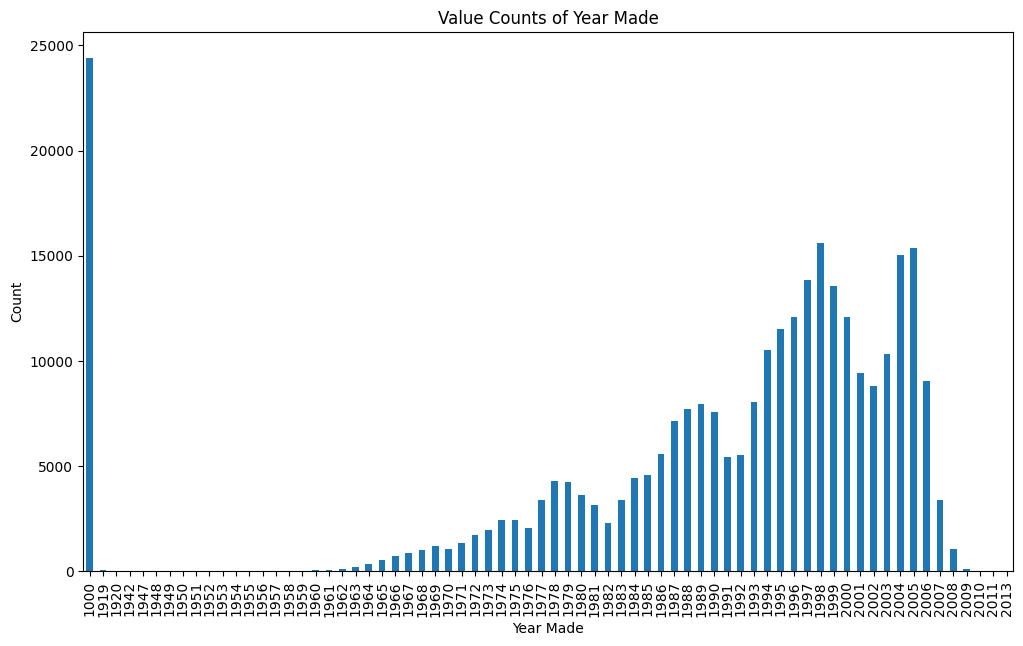


Convert Date Columns
Operation mode: train
Converted 'Sale_Date' to datetime.
Converted 'Year_Made' to numeric.

Handle Year Made Column
Operation mode: train
Input Dataset Rows: 292981

Create Date Features
Operation mode: train

Column data types and null counts:
Machine_Age_Years: int64, Null count: 0
Sale_Date_YYYYMM: int64, Null count: 0
Sale_Date_YYYY: int64, Null count: 0
Sale_Date_MM: int64, Null count: 0
Sale_Date_DD: int64, Null count: 0

Explore year made
Operation mode: train

year_made_value_counts: {year_made_value_counts}



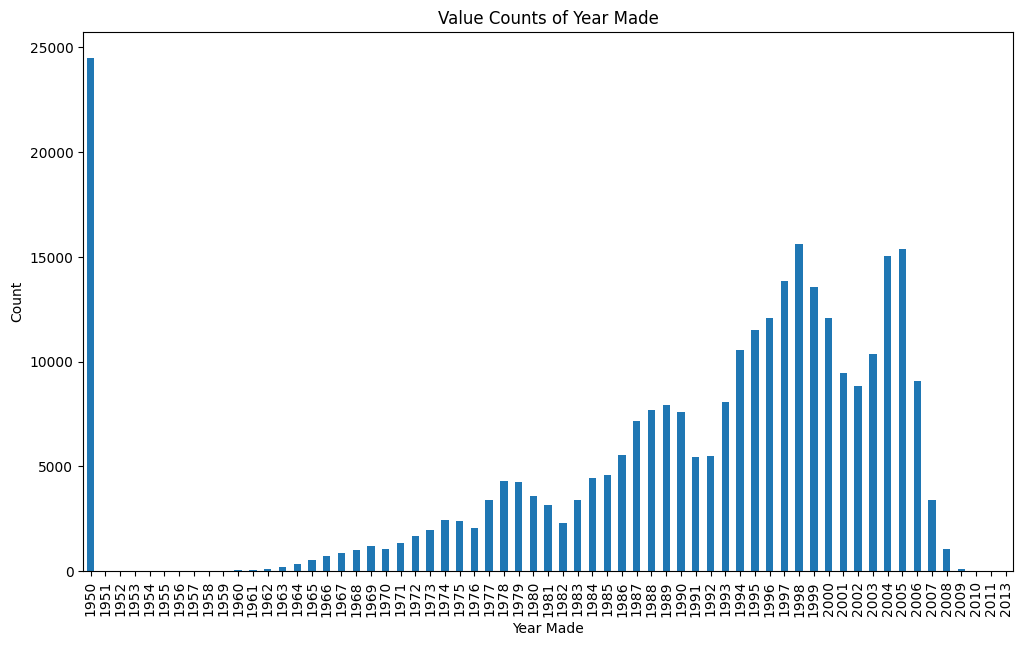


cAlculate and Add hand no column
Operation mode: train

Replace null values and blanks of string columns text
Operation mode: train

Counts of 'None or Unspecified' replacements for each column:

Fi_Base_Model: 0

Unspecified_count_dict: {'Fi_Base_Model': np.int64(0)}

Replace null values and blanks of string columns text
Operation mode: train

Counts of 'None or Unspecified' replacements for each column:

Fi_Secondary_Desc: 97390

Unspecified_count_dict: {'Fi_Secondary_Desc': np.int64(97390)}

Imputing mode for column: Fi_Secondary_Desc
Group columns list: ['Fi_Base_Model']
Operation mode: train
Adding missing indicator column: True
Initial NaN count in 'Fi_Secondary_Desc': 0
NaN count after grouping by 'Fi_Base_Model' and imputing in 'Fi_Secondary_Desc': 0
Final NaN count in 'Fi_Secondary_Desc': 0

Replace null values and blanks of string columns text
Operation mode: train

Counts of 'None or Unspecified' replacements for each column:

Fi_Model_Series: 257694

Unspecified_count_dict

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10896\1018221474.py:76: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  impute_func = lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)


NaN count after grouping by 'Fi_Model_Desc' and imputing in 'Fi_Model_Series': 0
Final NaN count in 'Fi_Model_Series': 0

Replace null values and blanks of string columns text
Operation mode: train

Counts of 'None or Unspecified' replacements for each column:

Fi_Model_Descriptor: 241959

Unspecified_count_dict: {'Fi_Model_Descriptor': np.int64(241959)}

Imputing mode for column: Usage_Band
Group columns list: ['Fi_Base_Model']
Operation mode: train
Adding missing indicator column: True
Initial NaN count in 'Usage_Band': 242595


C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10896\1018221474.py:76: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  impute_func = lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)


NaN count after grouping by 'Fi_Base_Model' and imputing in 'Usage_Band': 4453
Final NaN count in 'Usage_Band': 0

Replace null values and blanks of string columns text
Operation mode: train

Counts of 'None or Unspecified' replacements for each column:

Usage_Band: 0

Unspecified_count_dict: {'Usage_Band': np.int64(0)}

Imputing mode for column: Product_Size
Group columns list: ['Fi_Base_Model']
Operation mode: train
Adding missing indicator column: True
Initial NaN count in 'Product_Size': 156559


C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10896\1018221474.py:76: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  impute_func = lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)


NaN count after grouping by 'Fi_Base_Model' and imputing in 'Product_Size': 116735
Final NaN count in 'Product_Size': 0

Replace null values and blanks of string columns text
Operation mode: train

Counts of 'None or Unspecified' replacements for each column:

Product_Size: 0

Unspecified_count_dict: {'Product_Size': np.int64(0)}

Replace null values and blanks of string columns text
Operation mode: train

Counts of 'None or Unspecified' replacements for each column:

Product_Group: 0

Unspecified_count_dict: {'Product_Group': np.int64(0)}

Esplit_text_col
Operation mode: train

 Count Dictionary: {'total_rows': 292981, 'rows_with_delimiter': np.int64(292981), 'rows_without_delimiter': np.int64(0), 'rows_with_part1_only': np.int64(0), 'rows_with_default_text': np.int64(0)}

Replace null values and blanks of string columns text
Operation mode: train

Counts of 'None or Unspecified' replacements for each column:

Fi_Product_Class_Desc_Part1: 0

Unspecified_count_dict: {'Fi_Product_Class_

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10896\325981396.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Machine_Hours_Current_Meter'].replace(-1, np.nan, inplace=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10896\325981396.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting va


Plot pair histograms for comparing values
Operation mode: train Before Change


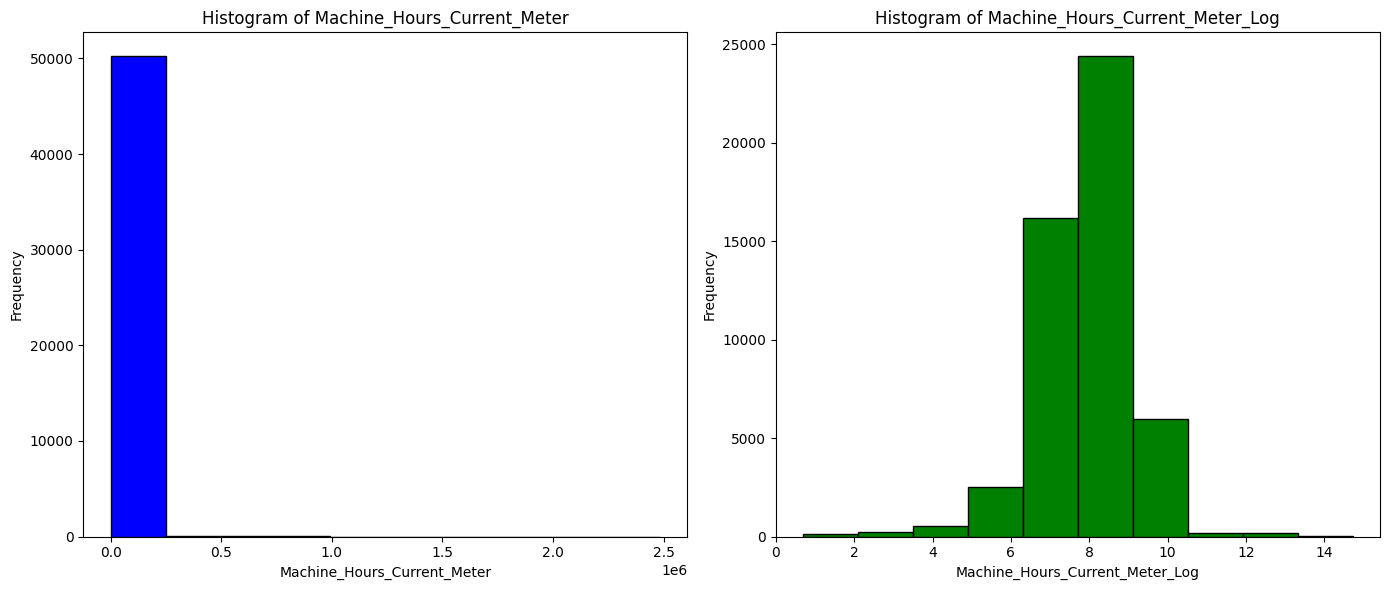


Imputing mean for column: Machine_Hours_Current_Meter
Group columns list: ['Fi_Base_Model']
Operation mode: train
Adding missing indicator column: True
Initial NaN count in 'Machine_Hours_Current_Meter': 242595
NaN count after grouping by 'Fi_Base_Model' and imputing in 'Machine_Hours_Current_Meter': 4453
Final NaN count in 'Machine_Hours_Current_Meter': 0

Imputing mean for column: Machine_Hours_Current_Meter_Log
Group columns list: ['Fi_Base_Model']
Operation mode: train
Adding missing indicator column: True
Initial NaN count in 'Machine_Hours_Current_Meter_Log': 242595
NaN count after grouping by 'Fi_Base_Model' and imputing in 'Machine_Hours_Current_Meter_Log': 4453
Final NaN count in 'Machine_Hours_Current_Meter_Log': 0

Plot pair histograms for comparing values
Operation mode: train After Change


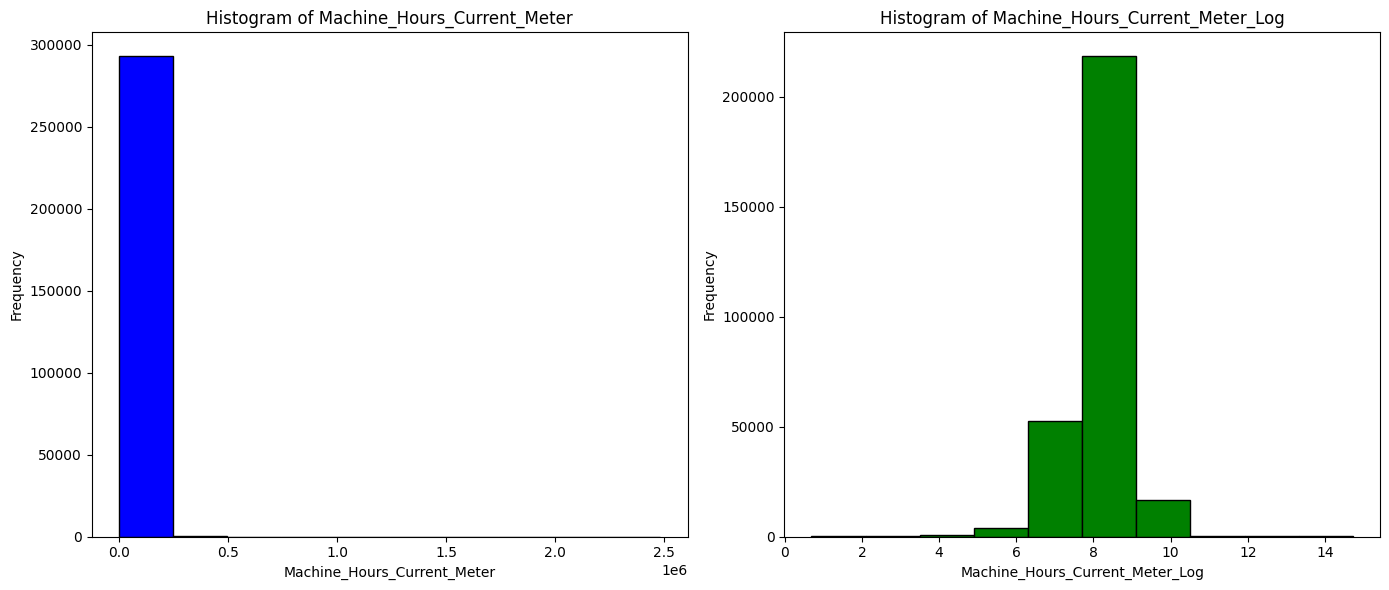


Cleans_tire_size
Operation mode: train

Replace null values and blanks of string columns text
Operation mode: train

Counts of 'None or Unspecified' replacements for each column:

Tire_Size: 222137

Unspecified_count_dict: {'Tire_Size': np.int64(222137)}

Removing double quotes from 'Tire_Size' column...

Replacing 'None or Unspecified' with NaN in 'Tire_Size' column...

Converting {col} column to float...
Tire_Size
NaN          257526
20.5          11560
14.0           6570
23.5           6519
17.5           4173
26.5           3283
29.5           1961
15.5            778
13.0            576
23.1             16
7.0              15
10.0              4
Name: count, dtype: int64


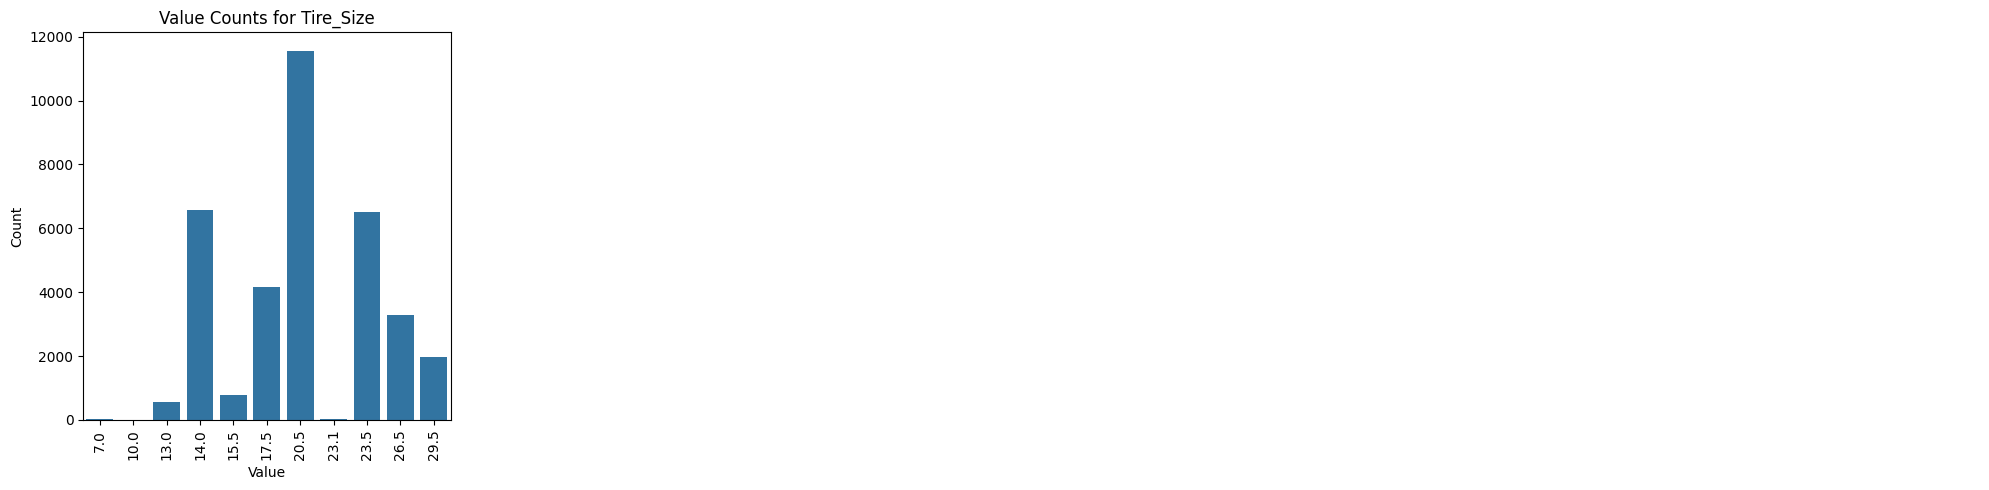

Tire_Size
20.5         269086
14.0           6570
23.5           6519
17.5           4173
26.5           3283
29.5           1961
15.5            778
13.0            576
23.1             16
7.0              15
10.0              4
Name: count, dtype: int64


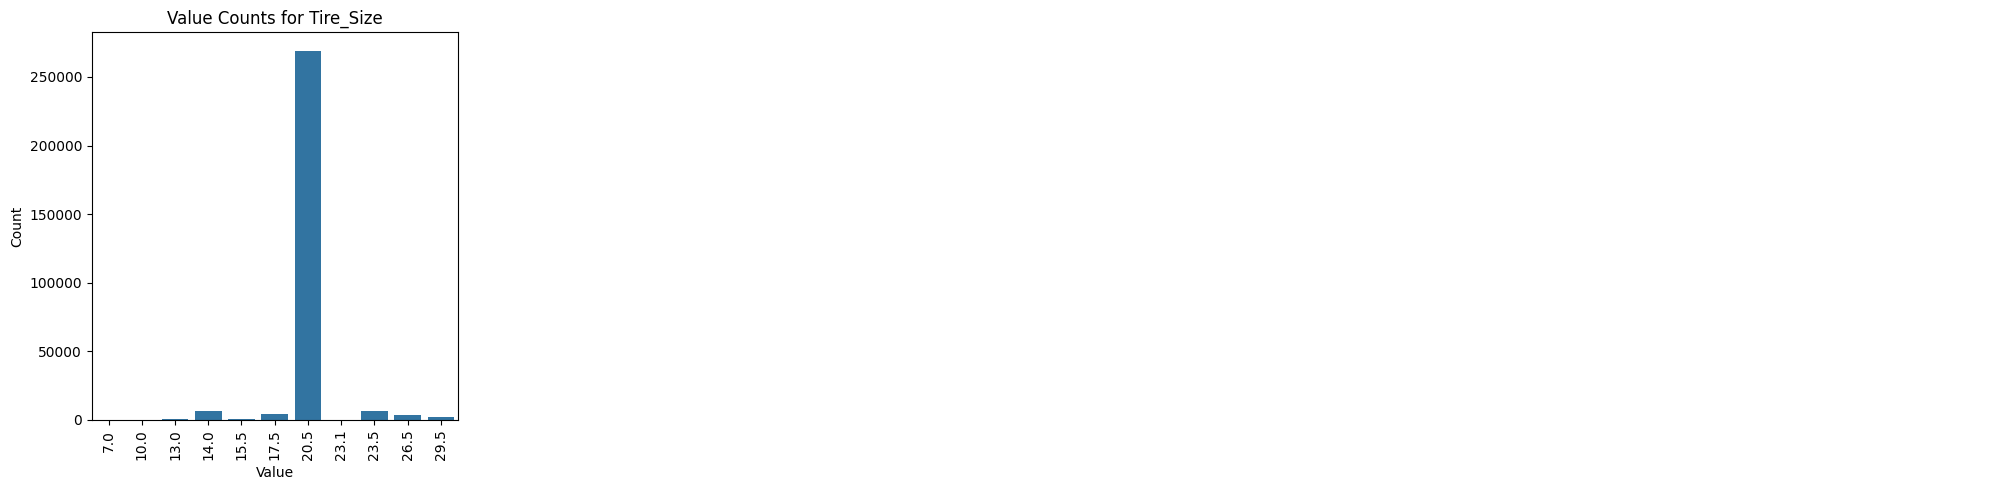


Replace null values and blanks of string columns text
Operation mode: train

Counts of 'None or Unspecified' replacements for each column:

Travel_Controls: 235596
Blade_Type: 235596
Backhoe_Mounting: 235946
Grouser_Type: 222350
Pattern_Changer: 222319
Thumb: 222290
Stick_Length: 222319
Undercarriage_Pad_Width: 222102
Track_Type: 222350
Hydraulics_Flow: 260693
Grouser_Tracks: 260693
Coupler_System: 260669
Coupler: 137943
Tip_Control: 273829
Scarifier: 273821
Ripper: 216679
Push_Block: 273829
Engine_Horsepower: 273829
Enclosure_Type: 273829
Blade_Width: 273829
Blade_Extension: 273829
Turbo_Charged: 232567
Stick: 232567
Ride_Control: 180932
Pad_Type: 232567
Forks: 148602
Drive_System: 213414
Product_Group: 0
Fi_Base_Model: 0
Fi_Model_Desc: 0
Fi_Secondary_Desc: 0
Fi_Model_Descriptor: 0

Unspecified_count_dict: {'Travel_Controls': np.int64(235596), 'Blade_Type': np.int64(235596), 'Backhoe_Mounting': np.int64(235946), 'Grouser_Type': np.int64(222350), 'Pattern_Changer': np.int64(222319), '

In [294]:
# Build X train
X_train = logic_build (X_train_init, mode='train', df_other=None)

In [295]:
# Backup Xy train
Xy_train = stich_df_to_list (X_train, y_train, "Sale_Price")
save_df_as_file (Xy_train, 'Xy_train')

Length of Sale_Price list is: 292981
Length of df is: 292981
DataFrame saved to Xy_train-2024-07-19_1931.csv
DataFrame saved to Xy_train-2024-07-19_1931.zip



Dropping Selected Columns
Operation mode: test
Number of columns in input df: 51

Column: 'Product_Group_Desc' dropped

Explore year made
Operation mode: test

year_made_value_counts: {year_made_value_counts}



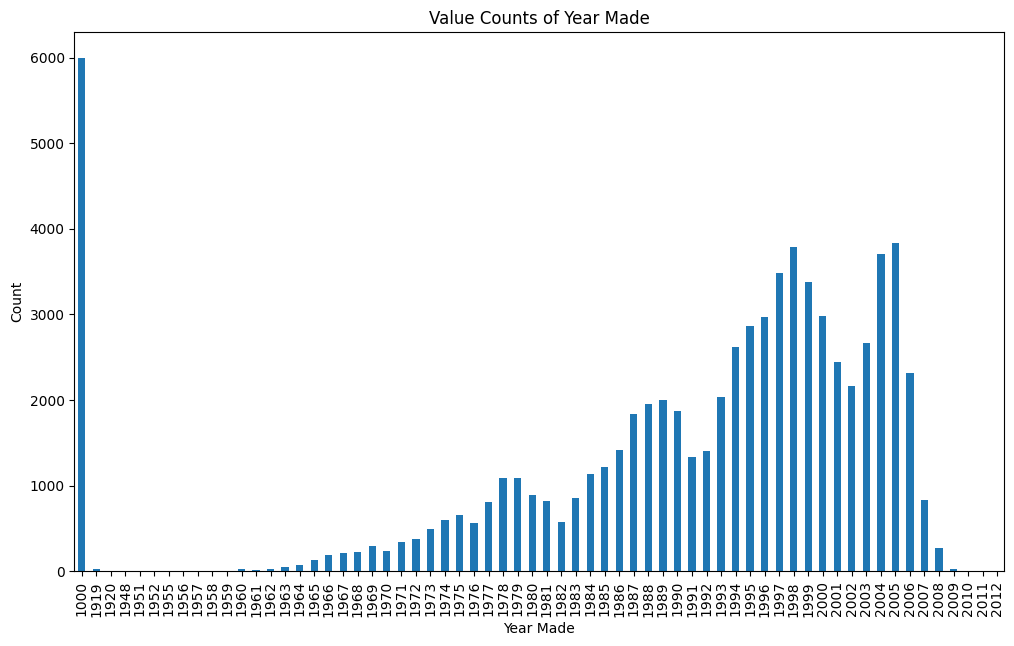


Convert Date Columns
Operation mode: test
Converted 'Sale_Date' to datetime.
Converted 'Year_Made' to numeric.

Handle Year Made Column
Operation mode: test
Input Dataset Rows: 73246

Create Date Features
Operation mode: test

Column data types and null counts:
Machine_Age_Years: int64, Null count: 0
Sale_Date_YYYYMM: int64, Null count: 0
Sale_Date_YYYY: int64, Null count: 0
Sale_Date_MM: int64, Null count: 0
Sale_Date_DD: int64, Null count: 0

Explore year made
Operation mode: test

year_made_value_counts: {year_made_value_counts}



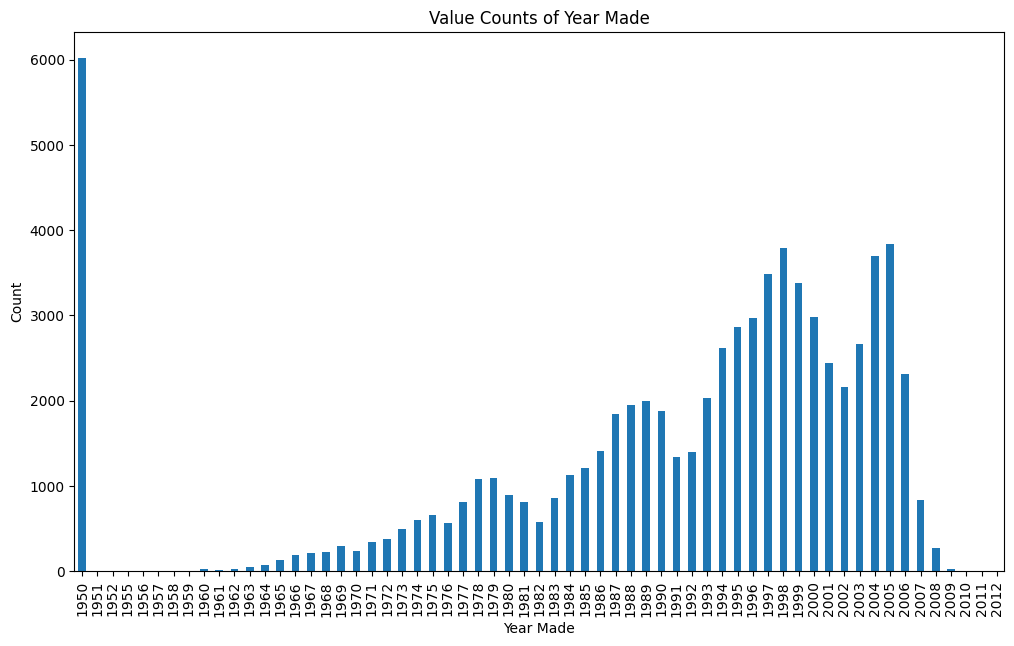


cAlculate and Add hand no column
Operation mode: test

Replace null values and blanks of string columns text
Operation mode: test

Counts of 'None or Unspecified' replacements for each column:

Fi_Base_Model: 0

Unspecified_count_dict: {'Fi_Base_Model': np.int64(0)}

Replace null values and blanks of string columns text
Operation mode: test

Counts of 'None or Unspecified' replacements for each column:

Fi_Secondary_Desc: 24291

Unspecified_count_dict: {'Fi_Secondary_Desc': np.int64(24291)}

Imputing mode for column: Fi_Secondary_Desc
Group columns list: ['Fi_Base_Model']
Operation mode: test
Adding missing indicator column: True
Initial NaN count in 'Fi_Secondary_Desc': 0


C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10896\1018221474.py:80: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mask = look_at_df.groupby(level)[col].transform(impute_func)


NaN count after grouping by 'Fi_Base_Model' and imputing in 'Fi_Secondary_Desc': 0
Final NaN count in 'Fi_Secondary_Desc': 0

Replace null values and blanks of string columns text
Operation mode: test

Counts of 'None or Unspecified' replacements for each column:

Fi_Model_Series: 64559

Unspecified_count_dict: {'Fi_Model_Series': np.int64(64559)}

Imputing mode for column: Fi_Model_Series
Group columns list: ['Fi_Model_Desc']
Operation mode: test
Adding missing indicator column: True
Initial NaN count in 'Fi_Model_Series': 0


C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10896\1018221474.py:80: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mask = look_at_df.groupby(level)[col].transform(impute_func)


NaN count after grouping by 'Fi_Model_Desc' and imputing in 'Fi_Model_Series': 0
Final NaN count in 'Fi_Model_Series': 0

Replace null values and blanks of string columns text
Operation mode: test

Counts of 'None or Unspecified' replacements for each column:

Fi_Model_Descriptor: 60427

Unspecified_count_dict: {'Fi_Model_Descriptor': np.int64(60427)}

Imputing mode for column: Usage_Band
Group columns list: ['Fi_Base_Model']
Operation mode: test
Adding missing indicator column: True
Initial NaN count in 'Usage_Band': 60707


C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10896\1018221474.py:80: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mask = look_at_df.groupby(level)[col].transform(impute_func)


NaN count after grouping by 'Fi_Base_Model' and imputing in 'Usage_Band': 60707
Final NaN count in 'Usage_Band': 0

Replace null values and blanks of string columns text
Operation mode: test

Counts of 'None or Unspecified' replacements for each column:

Usage_Band: 0

Unspecified_count_dict: {'Usage_Band': np.int64(0)}

Imputing mode for column: Product_Size
Group columns list: ['Fi_Base_Model']
Operation mode: test
Adding missing indicator column: True
Initial NaN count in 'Product_Size': 39432


C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10896\1018221474.py:80: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mask = look_at_df.groupby(level)[col].transform(impute_func)


NaN count after grouping by 'Fi_Base_Model' and imputing in 'Product_Size': 39432
Final NaN count in 'Product_Size': 0

Replace null values and blanks of string columns text
Operation mode: test

Counts of 'None or Unspecified' replacements for each column:

Product_Size: 0

Unspecified_count_dict: {'Product_Size': np.int64(0)}

Replace null values and blanks of string columns text
Operation mode: test

Counts of 'None or Unspecified' replacements for each column:

Product_Group: 0

Unspecified_count_dict: {'Product_Group': np.int64(0)}

Esplit_text_col
Operation mode: test

 Count Dictionary: {'total_rows': 73246, 'rows_with_delimiter': np.int64(73246), 'rows_without_delimiter': np.int64(0), 'rows_with_part1_only': np.int64(0), 'rows_with_default_text': np.int64(0)}

Replace null values and blanks of string columns text
Operation mode: test

Counts of 'None or Unspecified' replacements for each column:

Fi_Product_Class_Desc_Part1: 0

Unspecified_count_dict: {'Fi_Product_Class_Desc_Pa

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10896\325981396.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Machine_Hours_Current_Meter'].replace(-1, np.nan, inplace=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10896\325981396.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting va

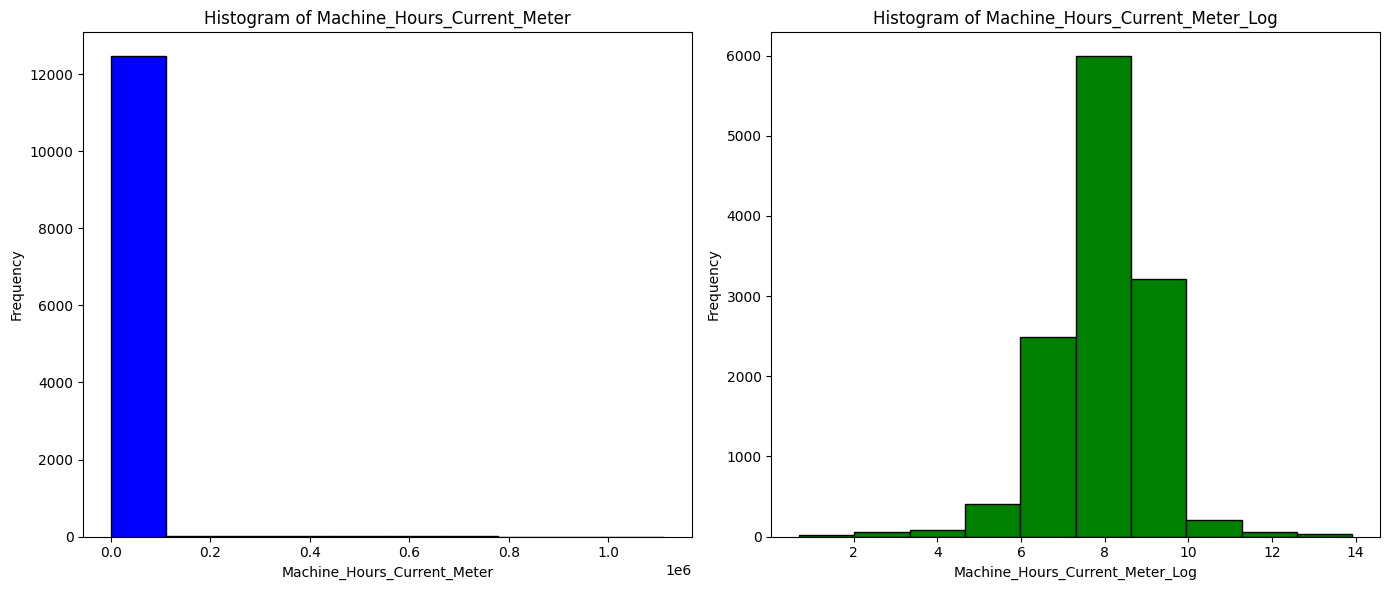


Imputing mean for column: Machine_Hours_Current_Meter
Group columns list: ['Fi_Base_Model']
Operation mode: test
Adding missing indicator column: True
Initial NaN count in 'Machine_Hours_Current_Meter': 60707


C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10896\1018221474.py:80: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mask = look_at_df.groupby(level)[col].transform(impute_func)


NaN count after grouping by 'Fi_Base_Model' and imputing in 'Machine_Hours_Current_Meter': 60707
Final NaN count in 'Machine_Hours_Current_Meter': 0

Imputing mean for column: Machine_Hours_Current_Meter_Log
Group columns list: ['Fi_Base_Model']
Operation mode: test
Adding missing indicator column: True
Initial NaN count in 'Machine_Hours_Current_Meter_Log': 60707


C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10896\1018221474.py:80: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mask = look_at_df.groupby(level)[col].transform(impute_func)


NaN count after grouping by 'Fi_Base_Model' and imputing in 'Machine_Hours_Current_Meter_Log': 60707
Final NaN count in 'Machine_Hours_Current_Meter_Log': 0

Plot pair histograms for comparing values
Operation mode: test After Change


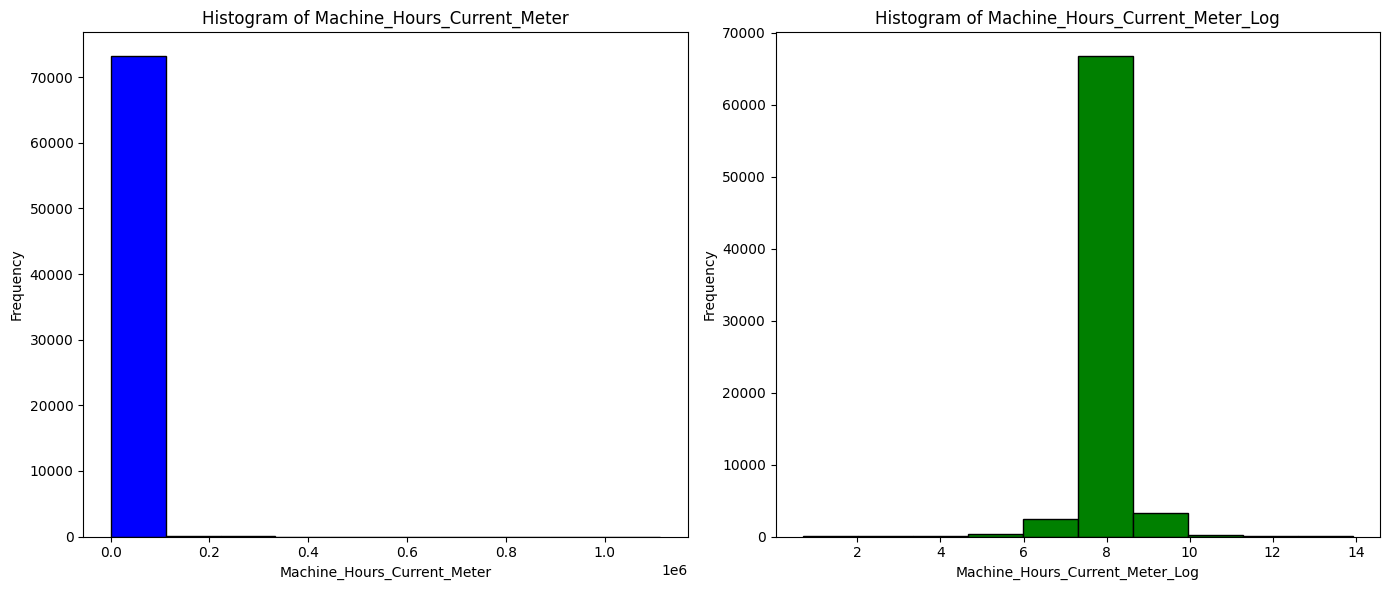


Cleans_tire_size
Operation mode: test

Replace null values and blanks of string columns text
Operation mode: test

Counts of 'None or Unspecified' replacements for each column:

Tire_Size: 55634

Unspecified_count_dict: {'Tire_Size': np.int64(55634)}

Removing double quotes from 'Tire_Size' column...

Replacing 'None or Unspecified' with NaN in 'Tire_Size' column...

Converting {col} column to float...
Tire_Size
NaN          64519
20.5          2829
14.0          1669
23.5          1630
17.5           991
26.5           791
29.5           475
15.5           210
13.0           126
10.0             2
7.0              2
23.1             2
Name: count, dtype: int64


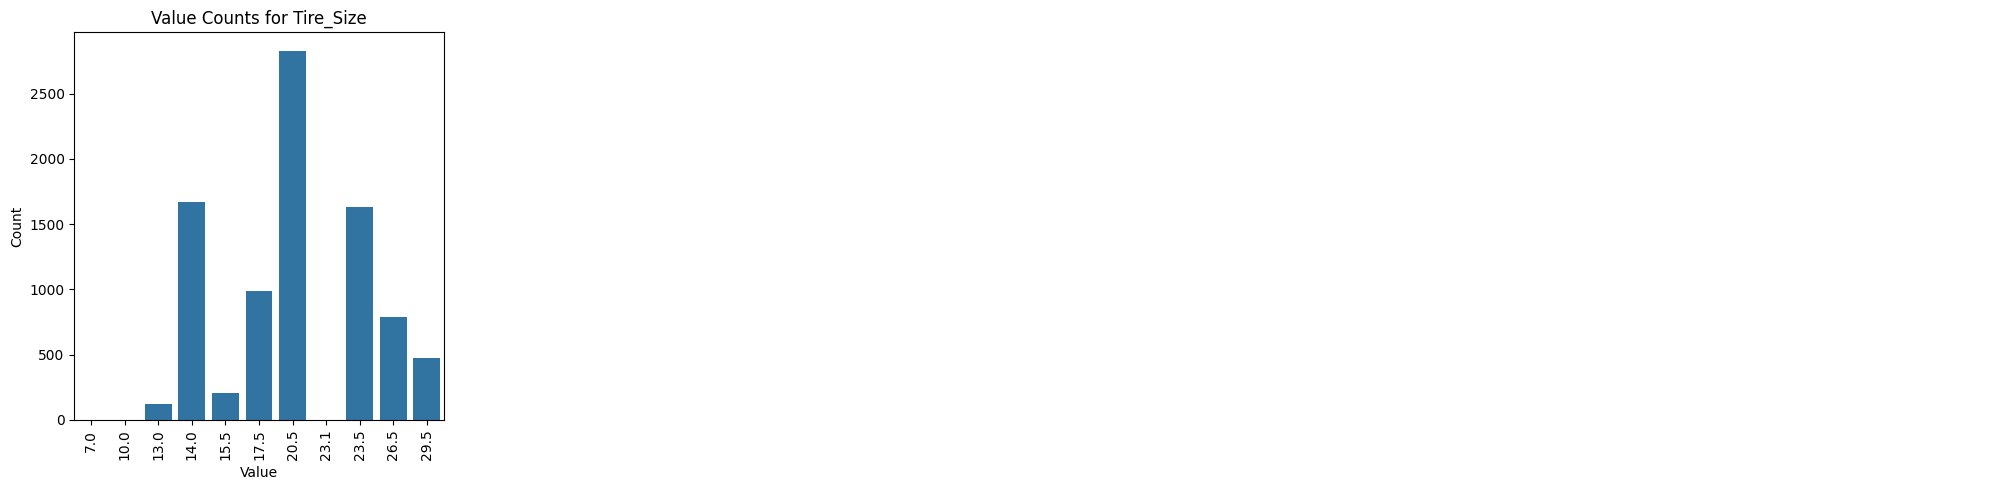

Tire_Size
20.5         67348
14.0          1669
23.5          1630
17.5           991
26.5           791
29.5           475
15.5           210
13.0           126
7.0              2
10.0             2
23.1             2
Name: count, dtype: int64


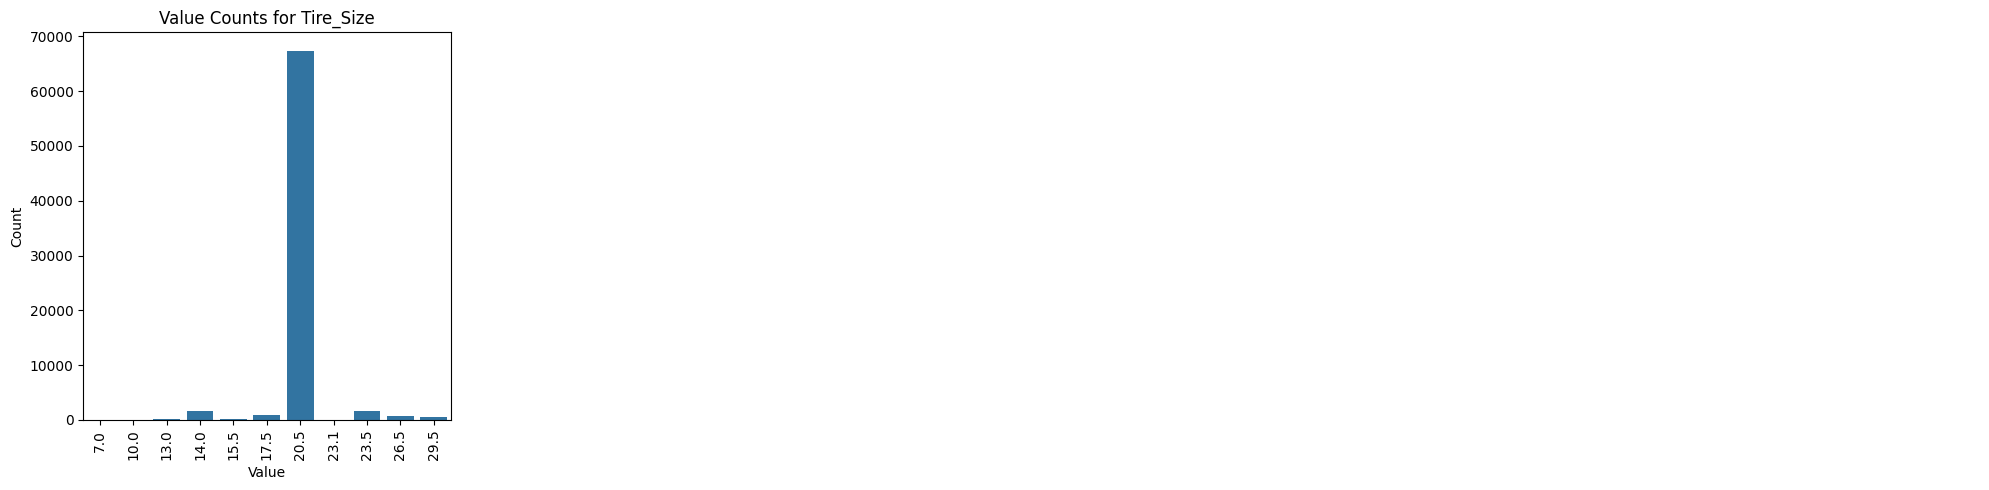


Replace null values and blanks of string columns text
Operation mode: test

Counts of 'None or Unspecified' replacements for each column:

Travel_Controls: 58781
Blade_Type: 58782
Backhoe_Mounting: 58851
Grouser_Type: 55915
Pattern_Changer: 55910
Thumb: 55904
Stick_Length: 55910
Undercarriage_Pad_Width: 55850
Track_Type: 55915
Hydraulics_Flow: 64930
Grouser_Tracks: 64930
Coupler_System: 64921
Coupler: 34662
Tip_Control: 68455
Scarifier: 68455
Ripper: 54041
Push_Block: 68455
Engine_Horsepower: 68455
Enclosure_Type: 68455
Blade_Width: 68455
Blade_Extension: 68455
Turbo_Charged: 58086
Stick: 58086
Ride_Control: 45288
Pad_Type: 58086
Forks: 36963
Drive_System: 53294
Product_Group: 0
Fi_Base_Model: 0
Fi_Model_Desc: 0
Fi_Secondary_Desc: 0
Fi_Model_Descriptor: 0

Unspecified_count_dict: {'Travel_Controls': np.int64(58781), 'Blade_Type': np.int64(58782), 'Backhoe_Mounting': np.int64(58851), 'Grouser_Type': np.int64(55915), 'Pattern_Changer': np.int64(55910), 'Thumb': np.int64(55904), 'Stick_L

In [296]:
### Build X test
X_test  = logic_build (X_test_init, mode='test', df_other=X_train)

In [297]:
# Backup Xy test
Xy_test = stich_df_to_list (X_test, y_test, "Sale_Price")
save_df_as_file (Xy_test, 'Xy_test')

Length of Sale_Price list is: 73246
Length of df is: 73246
DataFrame saved to Xy_test-2024-07-19_1932.csv
DataFrame saved to Xy_test-2024-07-19_1932.zip



Reading CSV file: valid.csv...
Number of rows in: {csv_file} : {num_rows}

Columns Renaimg for consistent naming convenssion...

Dropping Selected Columns
Operation mode: validation
Number of columns in input df: 51

Column: 'Product_Group_Desc' dropped

Explore year made
Operation mode: validation

year_made_value_counts: {year_made_value_counts}



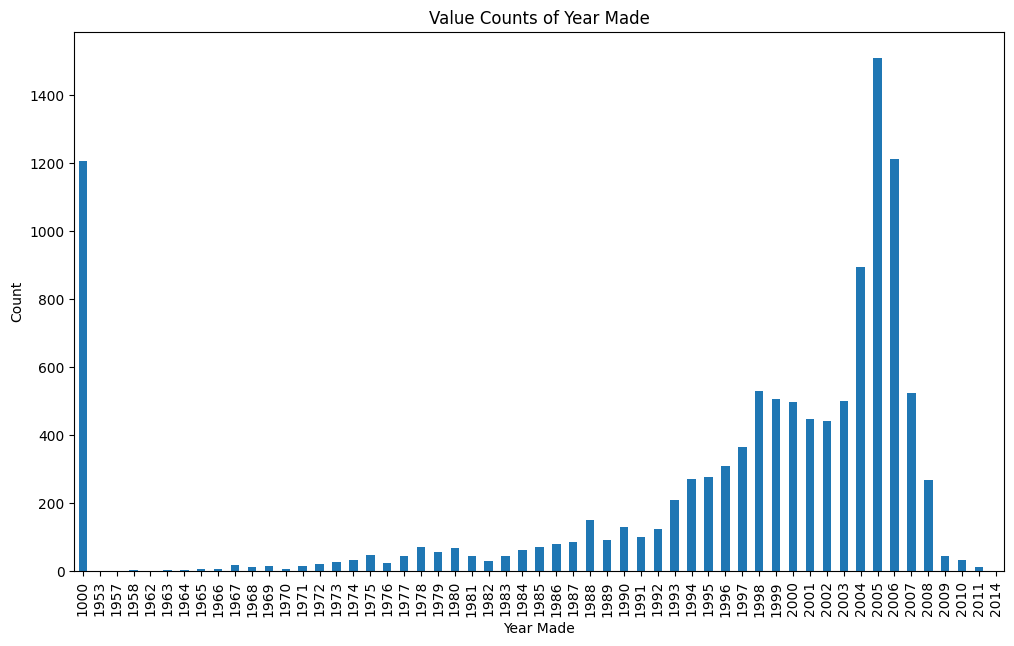


Convert Date Columns
Operation mode: validation
Converted 'Sale_Date' to datetime.
Converted 'Year_Made' to numeric.

Handle Year Made Column
Operation mode: validation
Input Dataset Rows: 11573

Create Date Features
Operation mode: validation

Column data types and null counts:
Machine_Age_Years: int64, Null count: 0
Sale_Date_YYYYMM: int64, Null count: 0
Sale_Date_YYYY: int64, Null count: 0
Sale_Date_MM: int64, Null count: 0
Sale_Date_DD: int64, Null count: 0

Explore year made
Operation mode: validation

year_made_value_counts: {year_made_value_counts}



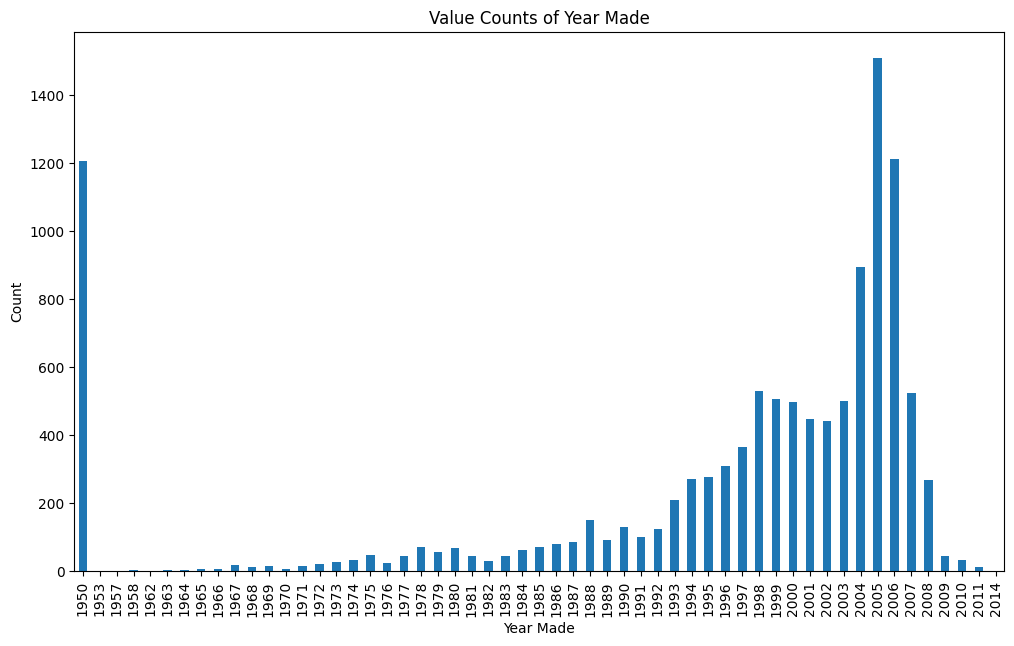


cAlculate and Add hand no column
Operation mode: validation

Replace null values and blanks of string columns text
Operation mode: validation

Counts of 'None or Unspecified' replacements for each column:

Fi_Base_Model: 0

Unspecified_count_dict: {'Fi_Base_Model': np.int64(0)}

Replace null values and blanks of string columns text
Operation mode: validation

Counts of 'None or Unspecified' replacements for each column:

Fi_Secondary_Desc: 3536

Unspecified_count_dict: {'Fi_Secondary_Desc': np.int64(3536)}

Imputing mode for column: Fi_Secondary_Desc
Group columns list: ['Fi_Base_Model']
Operation mode: validation
Adding missing indicator column: True
Initial NaN count in 'Fi_Secondary_Desc': 0


C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10896\1018221474.py:80: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mask = look_at_df.groupby(level)[col].transform(impute_func)


NaN count after grouping by 'Fi_Base_Model' and imputing in 'Fi_Secondary_Desc': 0
Final NaN count in 'Fi_Secondary_Desc': 0

Replace null values and blanks of string columns text
Operation mode: validation

Counts of 'None or Unspecified' replacements for each column:

Fi_Model_Series: 9814

Unspecified_count_dict: {'Fi_Model_Series': np.int64(9814)}

Imputing mode for column: Fi_Model_Series
Group columns list: ['Fi_Model_Desc']
Operation mode: validation
Adding missing indicator column: True
Initial NaN count in 'Fi_Model_Series': 0


C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10896\1018221474.py:80: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mask = look_at_df.groupby(level)[col].transform(impute_func)


NaN count after grouping by 'Fi_Model_Desc' and imputing in 'Fi_Model_Series': 0
Final NaN count in 'Fi_Model_Series': 0

Replace null values and blanks of string columns text
Operation mode: validation

Counts of 'None or Unspecified' replacements for each column:

Fi_Model_Descriptor: 8676

Unspecified_count_dict: {'Fi_Model_Descriptor': np.int64(8676)}

Imputing mode for column: Usage_Band
Group columns list: ['Fi_Base_Model']
Operation mode: validation
Adding missing indicator column: True
Initial NaN count in 'Usage_Band': 7542


C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10896\1018221474.py:80: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mask = look_at_df.groupby(level)[col].transform(impute_func)


NaN count after grouping by 'Fi_Base_Model' and imputing in 'Usage_Band': 7542
Final NaN count in 'Usage_Band': 0

Replace null values and blanks of string columns text
Operation mode: validation

Counts of 'None or Unspecified' replacements for each column:

Usage_Band: 0

Unspecified_count_dict: {'Usage_Band': np.int64(0)}

Imputing mode for column: Product_Size
Group columns list: ['Fi_Base_Model']
Operation mode: validation
Adding missing indicator column: True
Initial NaN count in 'Product_Size': 5830


C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10896\1018221474.py:80: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mask = look_at_df.groupby(level)[col].transform(impute_func)


NaN count after grouping by 'Fi_Base_Model' and imputing in 'Product_Size': 5830
Final NaN count in 'Product_Size': 0

Replace null values and blanks of string columns text
Operation mode: validation

Counts of 'None or Unspecified' replacements for each column:

Product_Size: 0

Unspecified_count_dict: {'Product_Size': np.int64(0)}

Replace null values and blanks of string columns text
Operation mode: validation

Counts of 'None or Unspecified' replacements for each column:

Product_Group: 0

Unspecified_count_dict: {'Product_Group': np.int64(0)}

Esplit_text_col
Operation mode: validation

 Count Dictionary: {'total_rows': 11573, 'rows_with_delimiter': np.int64(11573), 'rows_without_delimiter': np.int64(0), 'rows_with_part1_only': np.int64(0), 'rows_with_default_text': np.int64(0)}

Replace null values and blanks of string columns text
Operation mode: validation

Counts of 'None or Unspecified' replacements for each column:

Fi_Product_Class_Desc_Part1: 0

Unspecified_count_dict: {'F

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10896\325981396.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Machine_Hours_Current_Meter'].replace(-1, np.nan, inplace=True)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10896\325981396.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting va

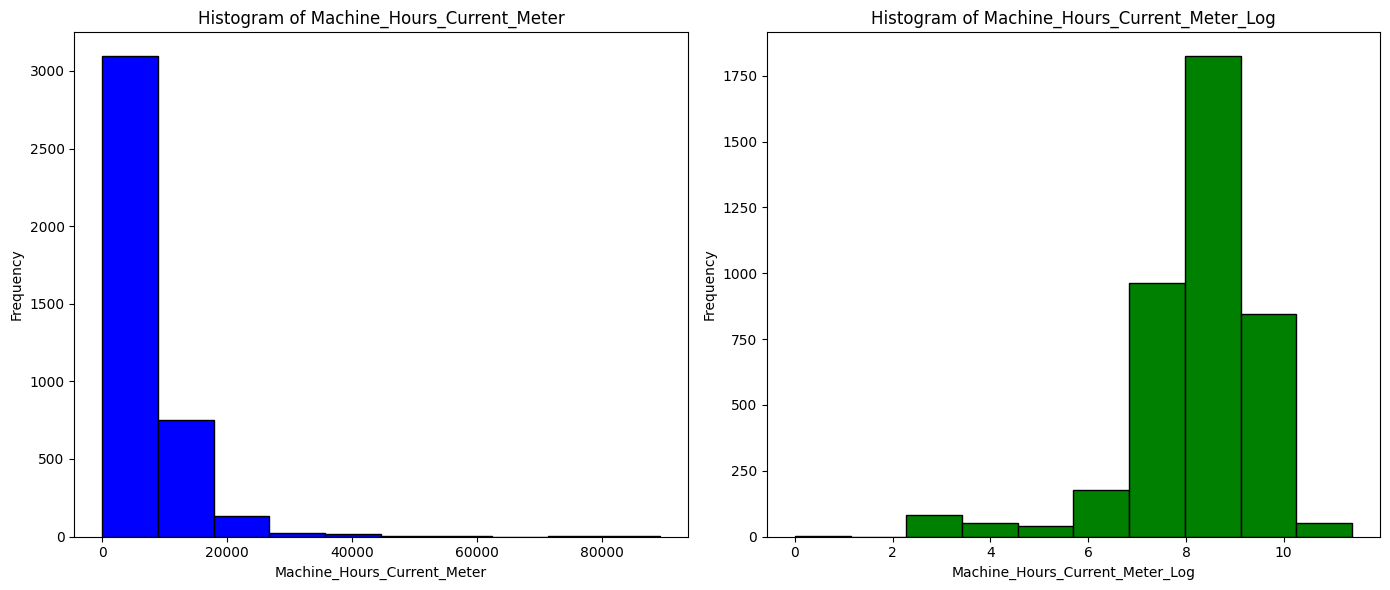


Imputing mean for column: Machine_Hours_Current_Meter
Group columns list: ['Fi_Base_Model']
Operation mode: validation
Adding missing indicator column: True
Initial NaN count in 'Machine_Hours_Current_Meter': 7542


C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10896\1018221474.py:80: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mask = look_at_df.groupby(level)[col].transform(impute_func)


NaN count after grouping by 'Fi_Base_Model' and imputing in 'Machine_Hours_Current_Meter': 7542
Final NaN count in 'Machine_Hours_Current_Meter': 0

Imputing mean for column: Machine_Hours_Current_Meter_Log
Group columns list: ['Fi_Base_Model']
Operation mode: validation
Adding missing indicator column: True
Initial NaN count in 'Machine_Hours_Current_Meter_Log': 7542


C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_10896\1018221474.py:80: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mask = look_at_df.groupby(level)[col].transform(impute_func)


NaN count after grouping by 'Fi_Base_Model' and imputing in 'Machine_Hours_Current_Meter_Log': 7542
Final NaN count in 'Machine_Hours_Current_Meter_Log': 0

Plot pair histograms for comparing values
Operation mode: validation After Change


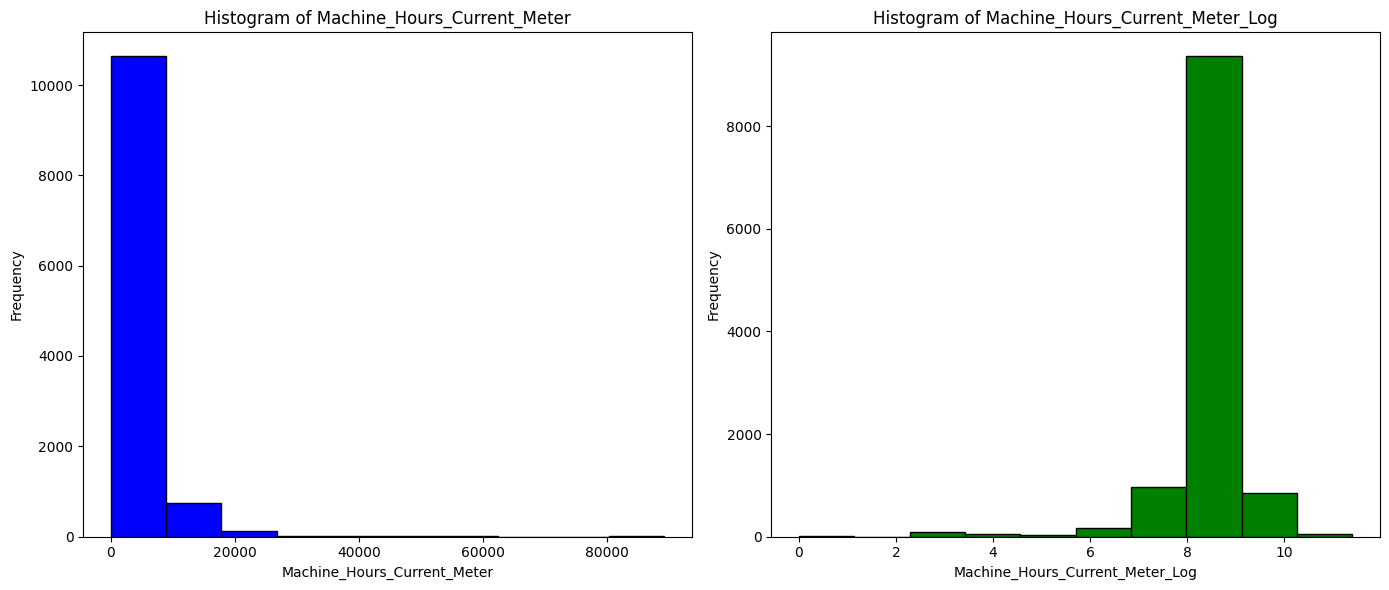


Cleans_tire_size
Operation mode: validation

Replace null values and blanks of string columns text
Operation mode: validation

Counts of 'None or Unspecified' replacements for each column:

Tire_Size: 8653

Unspecified_count_dict: {'Tire_Size': np.int64(8653)}

Removing double quotes from 'Tire_Size' column...

Replacing 'None or Unspecified' with NaN in 'Tire_Size' column...

Converting {col} column to float...
Tire_Size
NaN          10137
20.5           550
14.0           298
23.5           287
26.5           153
29.5            63
17.5            61
13.0            10
15.5             9
7.0              4
10.0             1
Name: count, dtype: int64


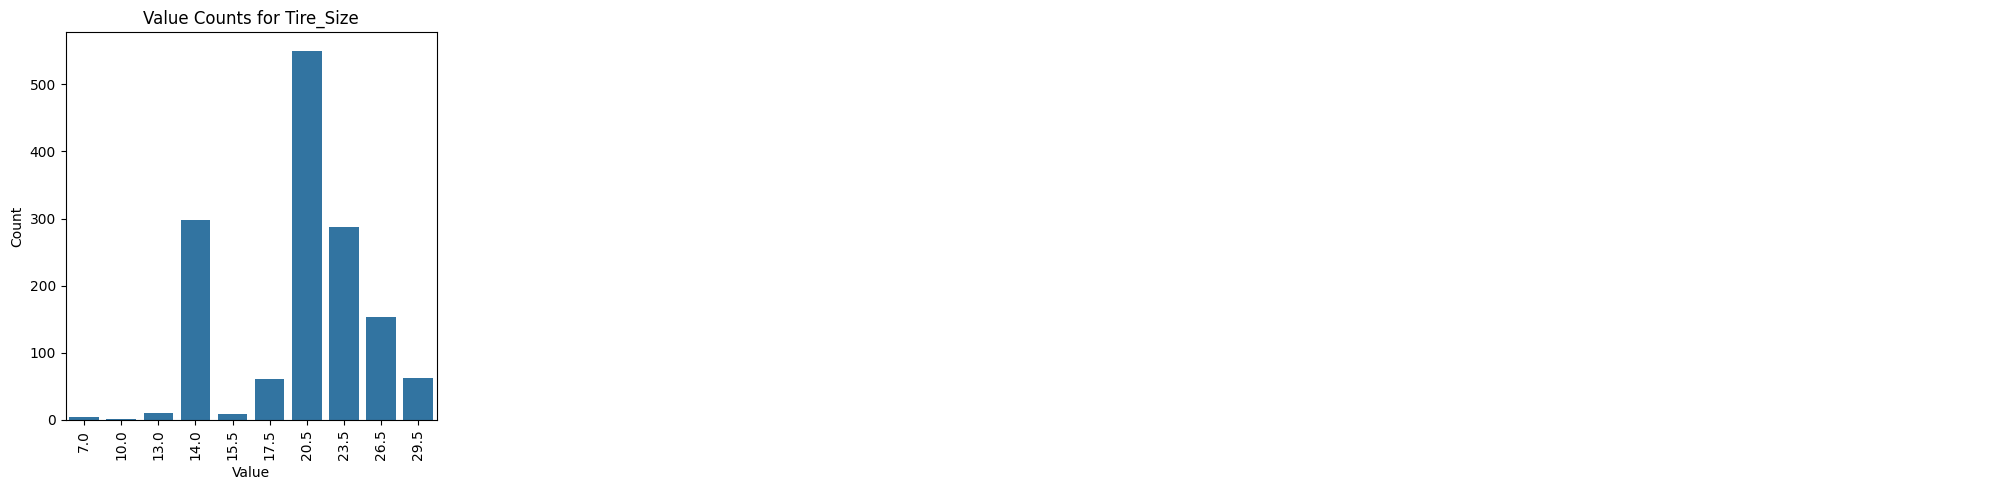

Tire_Size
20.5         10687
14.0           298
23.5           287
26.5           153
29.5            63
17.5            61
13.0            10
15.5             9
7.0              4
10.0             1
Name: count, dtype: int64


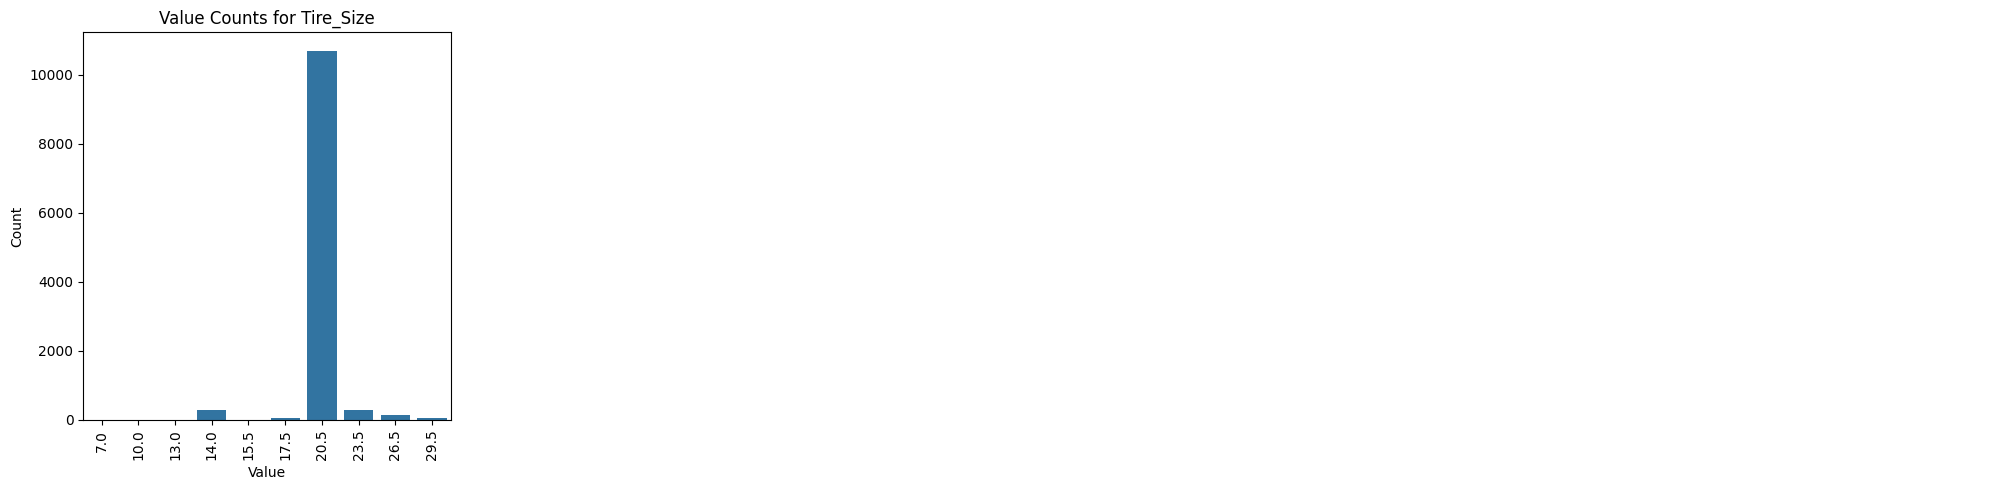


Replace null values and blanks of string columns text
Operation mode: validation

Counts of 'None or Unspecified' replacements for each column:

Travel_Controls: 9530
Blade_Type: 9531
Backhoe_Mounting: 9533
Grouser_Type: 8533
Pattern_Changer: 8530
Thumb: 8529
Stick_Length: 8530
Undercarriage_Pad_Width: 8529
Track_Type: 8533
Hydraulics_Flow: 10060
Grouser_Tracks: 10060
Coupler_System: 10057
Coupler: 4846
Tip_Control: 10809
Scarifier: 10809
Ripper: 8765
Push_Block: 10809
Engine_Horsepower: 10809
Enclosure_Type: 10809
Blade_Width: 10809
Blade_Extension: 10809
Turbo_Charged: 9611
Stick: 9611
Ride_Control: 7451
Pad_Type: 9611
Forks: 5935
Drive_System: 8847
Product_Group: 0
Fi_Base_Model: 0
Fi_Model_Desc: 0
Fi_Secondary_Desc: 0
Fi_Model_Descriptor: 0

Unspecified_count_dict: {'Travel_Controls': np.int64(9530), 'Blade_Type': np.int64(9531), 'Backhoe_Mounting': np.int64(9533), 'Grouser_Type': np.int64(8533), 'Pattern_Changer': np.int64(8530), 'Thumb': np.int64(8529), 'Stick_Length': np.int64(

In [298]:
### Build X Valid

### reading CSV already in storage to a df
X_valid_init = init_df('valid.csv')

### Preliminary prepation, NO Cleansing

# Naming convensions
X_valid_init = rename_columns(X_valid_init)   # use for train & test & validation

# Set Index
X_valid_init.set_index('Sales_ID', inplace=True)

X_valid = logic_build (X_valid_init, mode='validation', df_other=X_train)

In [299]:
#print (f"\n\n{X_train['Machine_Age_Years'].unique()}")
#print(f"\n\n{X_test['Machine_Age_Years'].unique()}")
#print(f"\n\n{X_valid['Machine_Age_Years'].unique()}")

In [300]:
def print_unique_and_count_negatives(df, label):
    unique_values = df['Machine_Age_Years'].unique()
    count_negatives = (df['Machine_Age_Years'] < 0).sum()
    print(f"\n\n{label} Unique Machine_Age_Years: {unique_values}")
    print(f"{label} Negative values count: {count_negatives}")

#print_unique_and_count_negatives(X_train, "X_train")
#print_unique_and_count_negatives(X_test, "X_test")
#print_unique_and_count_negatives(X_valid, "X_valid")

In [301]:
# show me distinct values of df['Year_Made']

#print (f"\n\n{X_train['Year_Made'].unique()}")
#print(f"\n\n{X_test['Year_Made'].unique()}")
#print(f"\n\n{X_valid['Year_Made'].unique()}")




*Until Here, pass to Guy to put mechanism in his Env. for further tuning & Analysis*

#**Building the Model**#

##**Estimating Regressor Memory**##

In [302]:
import pandas as pd

def estimate_rf_memory_usage(X_train, X_test, n_estimators, average_depth):
    print (f"\nEstimate the memory usage of a RandomForestRegressor")
    print (f"given the input training and test DataFrames and model parameters.")

    """
    Parameters:
    X_train (pd.DataFrame): The training DataFrame.
    X_test (pd.DataFrame):  The test DataFrame.
    n_estimators (int): The number of trees in the forest.
    average_depth (int): The average depth of the trees.

    Returns:
    float: Estimated memory usage in MB.
    """
    n_features = X_train.shape[1]

    # Rough estimate of nodes per level based on average depth
    nodes_per_level = 2 ** average_depth  # This is a rough estimate

    # Size per node in MB: let's assume it is 1.5 KB per feature for 75 features
    # Adjust proportionally based on the number of features
    size_per_node_mb = (n_features / 75) * 0.0015

    total_memory_mb = n_estimators * average_depth * nodes_per_level * size_per_node_mb
    return total_memory_mb

# Parameters
n_estimators  = 100
average_depth = 10

# Estimate memory usage
estimated_memory_usage = estimate_rf_memory_usage(X_train, X_test, n_estimators, average_depth)
print(f"Estimated Memory Usage for RandomForest with {X_train.shape[1]} features: {estimated_memory_usage:.2f} MB")



Estimate the memory usage of a RandomForestRegressor
given the input training and test DataFrames and model parameters.
Estimated Memory Usage for RandomForest with 65 features: 1331.20 MB


##**Limit the regressor**##
- Rows    == Samples --> X_train_sampeled, y_train_sampeled
- y range values     --> y_train_sampeled
- Columns == Features

In [303]:
# Create a sample X_train & y_tarin smaller dataset with 50,000 data points

# Scale the target variable to be between 4000 and 150000
# This normalizes the target variable, which can improve model performance and stability
# y_train_sampeled = 4000 + (y_train_sampeled - y_train_sampeled.min()) * (150000 - 4000) / (y_train_sampeled.max() - y_train_sampeled.min())

In [304]:
# Define the feature list to play with
feature_list = [
    "Machine_ID",
    "Model_ID",
    "Data_Source",
    "Auctioneer_ID",
    "Year_Made",
    "Sale_Date_YYYY",
    "Sale_Date_DD",
    "Machine_Age_Years",
    "Hand_No",
    "Machine_Hours_Current_Meter_Log",
    "Usage_Band",
    "Fi_Base_Model",
    "Product_Size",
    "State",
    "Product_Group",
    "Fi_Product_Class_Desc_Part1",
    "Fi_Product_Class_Desc_Part2",
    "Machine_Hours_Current_Meter_Log-Missing",
]
 
# Identify missing columns at the feature list to run the Regressor with
missing_columns_train = [col for col in feature_list if col not in X_train.columns]

# Remove missing columns, and creating a filtered feature list
if missing_columns_train:
    print(f"Columns missing in X_train and X_test: {missing_columns_train}")
    filtered_feature_list = [col for col in feature_list if col not in missing_columns_train]
else:
    filtered_feature_list = feature_list
print(f"Filtered feature list: {filtered_feature_list}")

# Setting the regressor input Columns
filtered_X_train = X_train[filtered_feature_list]
filtered_X_test  = X_test[filtered_feature_list]
filtered_X_valid = X_valid[filtered_feature_list]

Filtered feature list: ['Machine_ID', 'Model_ID', 'Data_Source', 'Auctioneer_ID', 'Year_Made', 'Sale_Date_YYYY', 'Sale_Date_DD', 'Machine_Age_Years', 'Hand_No', 'Machine_Hours_Current_Meter_Log', 'Usage_Band', 'Fi_Base_Model', 'Product_Size', 'State', 'Product_Group', 'Fi_Product_Class_Desc_Part1', 'Fi_Product_Class_Desc_Part2', 'Machine_Hours_Current_Meter_Log-Missing']


##**Running the Regressor**##
- Setting feature for model
- Training on X Train
- Predicting on X Test
- Predicting on X Valid

##**Summary**##
On Y axis We can run the regressor on:  
- y_train & y_test ------------------> Predicting `Sales_Price`
- y_train_log & y_test_log -----> Predicting `Sales_Price_log`

##**NOTE!**##
On validation we have to remember that if we decided to forecast `Sales_Price_log`,  
than the outcome will be logaritmic, and we have to calculate them back to numeric before sending to evaluation!!!

In [305]:
# Choosing the model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score
import numpy as np

model = RandomForestRegressor(random_state=42)  # Set random state for reproducibility

In [306]:
# Working on Regular Sales

# Training
model.fit(filtered_X_train, y_train)
y_train_pred = model.predict(filtered_X_train)

# Testing
y_test_pred = model.predict(filtered_X_test)

# Validation
y_valid_pred = model.predict(filtered_X_valid)

# Measuring Results
def RMSE(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

# Print the standard deviations and RMSE for training, testing, and validation
print(f'\ny_train STD:', y_train.std())
print(f'y_train pred STD:', y_train_pred.std())
print(f'y_train RMSE:', RMSE(y_train, y_train_pred))

print(f'\ny_test STD:', y_test.std())
print(f'y_test pred STD:', y_test_pred.std())
print(f'y_test RMSE:', RMSE(y_test, y_test_pred))

print(f'\ny_valid pred STD:', y_valid_pred.std())

# Calculate and print R^2 score
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'\ny_train R^2: {r2_train}')
print(f'y_test R^2: {r2_test}')



y_train STD: 23264.177156340276
y_train pred STD: 14961.108912269043
y_train RMSE: 9019.889653738464

y_test STD: 23161.084367777003
y_test pred STD: 4190.17771318392
y_test RMSE: 23979.137905443615

y_valid pred STD: 4158.336415427706

y_train R^2: 0.8496759254724798
y_test R^2: -0.07190249766620505


In [307]:
# Working on Logarithmic Sales
# Initialize the model

# Initialize the model
model = RandomForestRegressor()

# Training
model.fit(filtered_X_train, y_train_log)
y_train_pred_log = model.predict(filtered_X_train)

# Testing
y_test_pred_log = model.predict(filtered_X_test)

# Validation
y_valid_pred_log = model.predict(filtered_X_valid)

# Measuring Results
def RMSLE(y, y_pred):
    return np.sqrt(mean_squared_log_error(y, y_pred))

# Exponentiate the log predictions and actual values
y_train_pred_exp = np.exp(y_train_pred_log)
y_test_pred_exp  = np.exp(y_test_pred_log)
y_valid_pred_exp = np.exp(y_valid_pred_log)

y_train_exp  = np.exp(y_train_log)
y_test_exp   = np.exp(y_test_log)
y_valid_exp  = np.exp(y_valid_log)

print(f'\nPrint the standard deviations and RMSLE')
print(f'y_train_log STD:', y_train_log.std())
print(f'y_train_pred_log STD:', y_train_pred_log.std())
print(f'Train RMSLE:', RMSLE(y_train_log, y_train_pred_log))

print(f'\ny_test_log STD:', y_test_log.std())
print(f'y_test_pred_log STD:', y_test_pred_log.std())
print(f'Test RMSLE:', RMSLE(y_test_log, y_test_pred_log))

print(f'\ny_valid_log pred STD:', y_valid_pred_log.std())

print(f'\nPrint the standard deviations in the original scale')
print(f'y_train STD (original scale):', y_train_exp.std())
print(f'y_train pred STD (original scale):', y_train_pred_exp.std())

print(f'\ny_test STD (original scale):', y_test_exp.std())
print(f'y_test pred STD (original scale):', y_test_pred_exp.std())

print(f'\ny_valid pred STD (original scale):', y_valid_pred_exp.std())

print(f'\nCalculate and print R^2 score for the log values')
r2_train_log = r2_score(y_train_log, y_train_pred_log)
r2_test_log = r2_score(y_test_log, y_test_pred_log)
print(f'\ny_train_log R^2: {r2_train_log}')
print(f'y_test_log R^2: {r2_test_log}')

print(f'\nCalculate and print R^2 score for the original scale')
r2_train_exp = r2_score(y_train_exp, y_train_pred_exp)
r2_test_exp = r2_score(y_test_exp, y_test_pred_exp)
print(f'\ny_train R^2 (original scale): {r2_train_exp}')
print(f'y_test R^2 (original scale): {r2_test_exp}')




Print the standard deviations and RMSLE
y_train_log STD: 0.6969379870499853
y_train_pred_log STD: 0.44754192104267065
y_train RMSLE: 0.024247412783112248

y_test_log STD: 0.6975103433553876
y_test_pred_log STD: 0.10956676596799171
Test RMSLE: 0.06358159996450642

y_valid_log pred STD: 0.10244666255038305

Print the standard deviations in the original scale
y_train STD (original scale): 23264.177156340276
y_train pred STD (original scale): 12712.068515486144

y_test STD (original scale): 23161.084367777003
y_test pred STD (original scale): 2766.7580534177773

y_valid pred STD (original scale): 2621.828848811689

Calculate and print R^2 score for the log values

y_train_log R^2: 0.8512317049252345
y_test_log R^2: -0.024435209088720544

Calculate and print R^2 score for the original scale

y_train_log R^2: 0.7322791578152426
y_test_log R^2: -0.08665964291819694


#**Regressor Analysis**#

May be used for
- Training
- Testing
- Validation


###**Choose if we are going to analyse the Real sales or the Log Sales**###

- For real values - remain the same
- For log values - use log transformation of all y

In [ ]:
# Run this to create charts on logarithmic scale
y = y_log
y_train = y_train_log
y_train_pred = y_train_pred_log

y_test = y_test_log
y_test_pred = y_test_pred_log


In [ ]:
'''
Feature importances
Feature Importance Chart
Purpose: To understand which features are most important in your model's predictions.
Chart: Bar Chart
Tool: Seaborn or Matplotlib
'''
importances = model.feature_importances_

# Create a DataFrame for the feature importances
feature_importances = pd.DataFrame({
    'Feature': filtered_X_train.columns,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances')
plt.show()

In [ ]:
## Compute permutation feature importance
result = permutation_importance(model, filtered_X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

## Summarize feature importance
feature_importances = pd.DataFrame(result.importances_mean, index=X.columns, columns=['Permutation Importance'])
feature_importances['Feature importance'] = model.feature_importances_
feature_importances = feature_importances.sort_values(by='Permutation Importance', ascending=False)
feature_importances

In [ ]:
'''
Distribution Plots
Purpose: To visualize the distribution of a single feature.
Chart: Histogram or KDE Plot
Tool: Seaborn
'''
plt.figure(figsize=(10, 6))
sns.histplot(filtered_X_train['Year_Made'], kde=True)
plt.title('Distribution of Year Made')
plt.show()

In [ ]:
'''
Pair Plot
Purpose: To visualize relationships between multiple features.
Chart: Pair Plot
Tool: Seaborn
'''
sns.pairplot(filtered_X_train)
plt.title('Pair Plot of Features')
plt.show()

In [ ]:
'''
Box Plot
Purpose: To visualize the distribution of a feature and detect outliers.
Chart: Box Plot
Tool: Seaborn
'''
plt.figure(figsize=(10, 6))
sns.boxplot(x='Product_Size', y='Sale_Price', data=df)
plt.title('Box Plot of Product Size vs Sale Price')
plt.show()

In [ ]:
'''
Scatter Plot
Purpose: To visualize the relationship between two numerical features.
Chart: Scatter Plot
Tool: Seaborn or Matplotlib
'''
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Year_Made', y='Sale_Price', data=df)
plt.title('Scatter Plot of Year Made vs Sale Price')
plt.show()

In [ ]:
'''
Residual Plot
Purpose: To check the residuals (errors) of your model to see if they are randomly distributed.
Chart: Residual Plot
Tool: Seaborn
'''
plt.figure(figsize=(10, 6))
sns.residplot(x=y_test, y=y_test_pred, lowess=True, line_kws={'color': 'red'})
plt.title('Residual Plot')
plt.show()

In [ ]:
'''
Learning Curve
Purpose: To visualize the model performance on the training and validation datasets as the number of training samples increases.
Chart: Line Plot
'''
from sklearn.model_selection import learning_curve

# Learning curve
train_sizes, train_scores, test_scores = learning_curve(model, filtered_X_train, y_train_log, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Calculate mean and standard deviation
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score', color='r')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='g')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='r', alpha=0.1)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color='g', alpha=0.1)

plt.title('Learning Curve')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

#**Graphical Data Exploratiopn Analysis**#

In [ ]:
# .nuniques()

# Count unique values for each column
unique_counts = X_train.nunique().sort_values(ascending=False)
print("Number of unique values in each column:")
print(unique_counts)




In [ ]:
columns_list = ['Machine_Hours_Current_Meter',
                'Usage_Band',
                'Fi_Base_Model',
                'Fi_Secondary_Desc',
                'Fi_Model_Series',
                'Fi_Model_Descriptor',
                'Product_Size',
                'Fi_Product_Class_Desc',
                'State',
                'Product_Group',
                'Drive_System',
                'Enclosure',
                'Forks',
                'Pad_Type',
                'Ride_Control',
                'Stick',
                'Transmission',
                'Turbo_Charged',
                'Blade_Extension',
                'Blade_Width',
                'Enclosure_Type',
                'Engine_Horsepower',
                'Hydraulics',
                'Push_Block',
                'Ripper',
                ]

multi_col_stick_plot(X_train, columns_list)


In [ ]:
columns_list = ['Scarifier',
                'Tip_Control',
                'Tire_Size',
                'Coupler',
                'Coupler_System',
                'Grouser_Tracks',
                'Hydraulics_Flow',
                'Track_Type',
                'Undercarriage_Pad_Width',
                'Stick_Length',
                'Thumb',
                'Pattern_Changer',
                'Grouser_Type',
                'Backhoe_Mounting',
                'Blade_Type',
                'Travel_Controls',
                'Differential_Type',
                'Steering_Controls',
                'Year_Made',
                'Sale_Date_YYYY',
                'Sale_Date_MM',
                'Sale_Date_DD',
               ]
multi_col_stick_plot(X_train, columns_list)

In [ ]:
# Correlation Matrix

# Option 1: sending all DF with all columns
columns_list1 = [#'Sale_Price',#
                'Machine_ID',
                'Model_ID',
                'Auctioneer_ID',
                'Year_Made',
                'Machine_Hours_Current_Meter',
                'Usage_Band',
                'Sale_Date',
                'Fi_Model_Desc',
                'Fi_Base_Model',
                'Fi_Secondary_Desc',
                'Fi_Model_Series',
                'Fi_Model_Descriptor',
                'Product_Size',
                'Fi_Product_Class_Desc',
                'Product_Group',
                'Product_Group_Desc',
                'Drive_System',
                'Enclosure',
                'Forks',
                'Pad_Type',
                'Ride_Control',
                'Stick',
                'Transmission',
                'Turbo_Charged',
                'Blade_Extension',
                'Blade_Width',
                'Enclosure_Type',
                'Engine_Horsepower',
                'Hydraulics',
                'Push_Block',
                'Ripper',
                'Scarifier',
                'Tip_Control',
                'Tire_Size',
                'Coupler',
                'Coupler_System',
                'Grouser_Tracks',
                'Hydraulics_Flow',
                'Track_Type',
                'Undercarriage_Pad_Width',
                'Stick_Length',
                'Thumb',
                'Pattern_Changer',
                'Grouser_Type',
                'Backhoe_Mounting',
                'Blade_Type',
                'Travel_Controls',
                'Differential_Type',
                'Steering_Controls',
                'Machine_Age_Years',
                'Sale_Date_YYYYMM',
                'Sale_Date_YYYY',
                'Sale_Date_MM',
                ]
# Option 2: only model feature_list
corr_matrix_plot (X_train,feature_list)

##**Tuning the Regressor Model Hyper parameters**##

In [ ]:
"""
Random Forest Hyperparameter Tuning with GridSearchCV

Parameters:
- n_estimators: The number of trees in the forest. Common values: [100, 200, 300, 400, 500].
    Increasing the number of trees generally improves performance but also increases computational cost.
- max_features: The number of features to consider when looking for the best split. Options: ['sqrt', 'log2', None].
    'sqrt' is typically a good default for regression tasks.
- max_depth: The maximum depth of the tree. Common values: [None, 10, 20, 30, 40, 50].
    Limiting the depth can prevent overfitting.
- min_samples_split: The minimum number of samples required to split an internal node. Common values: [2, 5, 10].
    Increasing this value can make the model more conservative.
- min_samples_leaf: The minimum number of samples required to be at a leaf node. Common values: [1, 2, 4].
    Increasing this value can smooth the model.
- bootstrap: Whether bootstrap samples are used when building trees. Options: [True, False].
    Using bootstrap samples can improve the robustness of the model.
- criterion: The function to measure the quality of a split. For regression, options are ['squared_error', 'absolute_error'].
    'squared_error' is mean squared error, and 'absolute_error' is mean absolute error.

This script will:
1. Create a sample dataset with 400,000 data points.
2. Scale the target variable.
3. Split the dataset into training and testing sets.
4. Perform feature engineering and imputation on the data.
5. Define a parameter grid for the Random Forest model.
6. Perform a GridSearchCV to find the best hyperparameters.
7. Print the best parameters and the best score.
8. Fit the best model on the training data and predict on the test data.
9. Calculate and print the standard deviation and RMSE for both training and test datasets.
"""
"""
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 150, 200, 300, 400],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8],
    'bootstrap': [True, False],
    'criterion': ['squared_error', 'absolute_error']  # Updated to correct criteria for regression
}

# Create a base model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train_sampeled, y_train_sampeled)

# Print the best parameters and best score
print(f"Best model: {grid_search.best_estimator_}")
print(f"\nBest parameters found: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

# Fit the best model on the entire training data
best_rf = grid_search.best_estimator_
best_rf.fit(X_train_sampeled, y_train_sampeled)

# Predict on the training data
y_train_pred = best_rf.predict(X_train_sampeled)

# Predict on the test data
y_test_pred = best_rf.predict(X_test)

# Calculate standard deviation and RMSE for training data
std_train = np.std(y_train_sampeled)
rmse_train = np.sqrt(mean_squared_error(y_train_sampeled, y_train_pred))

# Calculate standard deviation and RMSE for test data
std_test = np.std(y_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Train Standard Deviation: {std_train}")
print(f"Train RMSE: {rmse_train}")
print(f"Test Standard Deviation: {std_test}")
print(f"Test RMSE: {rmse_test}")
"""



#**Submission**#
Creating a CSV file X_Valis `Sale_ID` and `y_pred_valid`


In [ ]:
# Reminder !
# Make predictions according to the project's model regressor

# filtered_X_valid = X_valid[filtered_feature_list]
# y_valid_pred = model.predict(filtered_X_valid)

# Backup Xy Valid at submission format:
# Sale_ID (index) & y_valid prediced (Sale_Price)
X_valid_temp = X_valid.drop(columns=X_valid.columns) # Remain only with Sale_ID index
Xy_valid = stich_df_to_list (X_valid_temp, y_valid_pred, "Sale_Price")
save_df_as_file (Xy_valid, 'Submit')

#**Old issues - Recycle bin**#

In [ ]:
''' From Michael
# init Arguments
#X_train10 = X_train.copy()
#X_test10  = X_test.copy()

####

X_train10 = X_train10.drop(columns=
              ['Machine_ID',
               'Auctioneer_ID',
               'Backhoe_Mounting',
               'Hydraulics',
               'Push_Block',
               'Ripper',
               'Scarifier',
               'Tip_Control',
               'Tire_Size',
               'Coupler_System',
               'Grouser_Tracks',
               'Hydraulics_Flow',
               'Undercarriage_Pad_Width',
               'Stick_Length',
               'Thumb',
               'Pattern_Changer',
               'Grouser_Type',
               'Sale_Date_YYYY',
               'Sale_Date_MM',
                               ])

X_test10 = X_test10.drop(columns=
              ['Machine_ID',
               'Auctioneer_ID',
               'Backhoe_Mounting',
               'Hydraulics',
               'Push_Block',
               'Ripper',
               'Scarifier',
               'Tip_Control',
               'Tire_Size',
               'Coupler_System',
               'Grouser_Tracks',
               'Hydraulics_Flow',
               'Undercarriage_Pad_Width',
               'Stick_Length',
               'Thumb',
               'Pattern_Changer',
               'Grouser_Type',
               'Sale_Date_YYYY',
               'Sale_Date_MM',
                               ])



# Training
# model = RandomForestRegressor()
# model.fit(X_train10, y_train)

# y_train_pred = model.predict(X_train10)

# y_test_pred = model.predict(X_test10)

#def RMSE(y, y_pred):
#    return np.sqrt(mean_squared_error(y, y_pred))

#print(f'Train RMSE:', RMSE(y_train, y_train_pred))
#print(f'Test RMSE:', RMSE(y_test, y_test_pred))
#print(y_test.std())

#X_train10.info()
#X_test10.info()

#X_train10.describe()
#X_test10.descibre()

#X_train10.columns()
#X_test10.columns()
'''


In [ ]:
def explore_machine_hours(df, col, group_cols, mode, df_other):
    print(f"\nExplore machine hours current meter")
    print(f"Operation mode: {mode}")

    # 1.1 Create a column Machine_Hours_Current_Meter-Missing set to True if NaN or zero
    df['Machine_Hours_Current_Meter-Missing'] = df['Machine_Hours_Current_Meter'].isna() | (df['Machine_Hours_Current_Meter'] == 0)
    print("\nAfter creating 'Machine_Hours_Current_Meter-Missing' column:")
    print(df)

    # 2.1 Replace the value in Machine_Hours_Current_Meter with -1 if NaN or zero
    df['Machine_Hours_Current_Meter'] = df['Machine_Hours_Current_Meter'].replace(np.nan, -1)
    df.loc[df['Machine_Hours_Current_Meter'] == 0, 'Machine_Hours_Current_Meter'] = -1
    print("\nAfter replacing NaN and zero values with -1 in 'Machine_Hours_Current_Meter':")
    print(df)

    # 2.2.1 Replace -1 with NaN in Machine_Hours_Current_Meter
    df['Machine_Hours_Current_Meter'].replace(-1, np.nan, inplace=True)

    # 2.2.2 Impute NaN values in Machine_Hours_Current_Meter by grouped mean
    for col in group_cols:
        group_means = df.groupby(col)['Machine_Hours_Current_Meter'].transform('mean')
        df['Machine_Hours_Current_Meter'].fillna(group_means, inplace=True)
    df['Machine_Hours_Current_Meter'].fillna(df['Machine_Hours_Current_Meter'].mean(), inplace=True)

    print("\nAfter imputing NaN values in 'Machine_Hours_Current_Meter':")
    print(df)

    # 3.1 Create a new column Machine_Hours_Current_Meter_Log based on Machine_Hours_Current_Meter
    df['Machine_Hours_Current_Meter_Log'] = df['Machine_Hours_Current_Meter'].apply(
        lambda x: np.log(x) if (pd.notna(x) and x > 0) else -1
    )
    print("\nAfter creating 'Machine_Hours_Current_Meter_Log' column:")
    print(df)

    # 4.2.1 Replace -1 with NaN in Machine_Hours_Current_Meter_Log
    df['Machine_Hours_Current_Meter_Log'].replace(-1, np.nan, inplace=True)

    # 4.3 Impute NaN values in Machine_Hours_Current_Meter_Log by grouped mean
    for col in group_cols:
        group_means_log = df.groupby(col)['Machine_Hours_Current_Meter_Log'].transform('mean')
        df['Machine_Hours_Current_Meter_Log'].fillna(group_means_log, inplace=True)
    df['Machine_Hours_Current_Meter_Log'].fillna(df['Machine_Hours_Current_Meter_Log'].mean(), inplace=True)


    print("\nAfter imputing remaining NaN values with global mean:")
    print(df)

    # Plot histograms
    plt.figure(figsize=(14, 6))

    # Histogram for Machine_Hours_Current_Meter
    plt.subplot(1, 2, 1)
    df['Machine_Hours_Current_Meter'].plot(kind='hist', bins=10, color='blue', edgecolor='black')
    plt.title('Histogram of Machine_Hours_Current_Meter')
    plt.xlabel('Machine_Hours_Current_Meter')
    plt.ylabel('Frequency')

    # Histogram for Machine_Hours_Current_Meter_Log
    plt.subplot(1, 2, 2)
    df['Machine_Hours_Current_Meter_Log'].plot(kind='hist', bins=10, color='green', edgecolor='black')
    plt.title('Histogram of Machine_Hours_Current_Meter_Log')
    plt.xlabel('Machine_Hours_Current_Meter_Log')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Example usage
sample_data = {
    'Machine_Hours_Current_Meter': [100, 0, np.nan, 400, 500, 600, 10, np.nan, 0, 1000, 2000, 2000],
    'Base_Model': ['A', 'A', 'B', 'B', 'A', 'A', 'B', 'B', 'A', 'A', 'B', 'B']
}
df_sample = pd.DataFrame(sample_data)

explore_machine_hours(df_sample, 'Machine_Hours_Current_Meter', ['Base_Model'], 'example_mode', None)


In [ ]:
# Function to replace NaN values based on the most frequent value within groups

def replace_nan_old1 (df, target_col, group_cols, mode, df_other):
    print(f"\nReplace NaN values based on the most frequent value within groups")
    print(f"Operation mode: {mode}")

    default_text = 'None or Unspecified'

    if mode == 'train':
      # Find the most frequent value within each group in the training data
      most_frequent = df.groupby(group_cols)[target_col].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else default_text)

    else:  # test or validation
      if df_other is None:
        raise ValueError("df_other must be provided in test or validation mode")
      else:
        # Find the most frequent value within each group in the training data
        most_frequent = df_other.groupby(group_cols)[target_col].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else default_text)

      # Count of rows processed
      rows_with_nan = df[target_col].isna().sum()
      print(f"Number of rows with NaN values in '{target_col}': {rows_with_nan}")

    # Define a function to fill NaN values based on the most frequent value in the group
    def fill_na(row):
        # Create a tuple from the group columns to match the index in most_frequent
        group_values = tuple(row[col] for col in group_cols)
        if pd.isna(row[target_col]):
            return most_frequent[group_values]
        return row[target_col]

    # Apply the function to fill NaN values
    df[target_col] = df.apply(fill_na, axis=1)

    # Count of rows processed
    rows_processed = df.shape[0]
    print(f"Number of rows processed: {rows_processed}")

    return (df)

In [ ]:
# Function to replace NaN values based on the most frequent value within groups
# Replace Numeric Nan by group hierarchy - Working

import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

class HierarchicalGroupImputer(BaseEstimator, TransformerMixin):
    def __init__(self, group_cols, target_col):
        self.group_cols = group_cols
        self.target_col = target_col
        self.group_modes = {}

    def fit(self, X, y=None):
        df = pd.DataFrame(X, columns=self.group_cols + [self.target_col])
        for i in range(len(self.group_cols), 0, -1):
            current_group_cols = self.group_cols[:i]
            current_modes = df.groupby(current_group_cols)[self.target_col].agg(
                lambda x: x.mean() if not x.empty else np.nan
            )
            self.group_modes[i] = current_modes.to_dict()
        return self

    def transform(self, X):
        df = pd.DataFrame(X, columns=self.group_cols + [self.target_col])
        result = df.copy()

        def impute_hierarchical(row):
            for i in range(len(self.group_cols), 0, -1):
                current_group_cols = self.group_cols[:i]
                group_key = tuple(row[col] for col in current_group_cols)
                if group_key in self.group_modes[i]:
                    return self.group_modes[i][group_key]
            return np.nan

        mask = result[self.target_col].isna()
        result.loc[mask, self.target_col] = result[mask].apply(impute_hierarchical, axis=1)
        return result.values

def replace_numeric_nan_mean(df, target_col, group_cols, mode, df_other=None):
    print(f"\nImpute missing values in the target column based on the group columns")
    print(f"Operation mode: {mode}")

    X = df[group_cols + [target_col]].copy()

    if mode == 'train':
        imputer = Pipeline([
            ('hierarchical', HierarchicalGroupImputer(group_cols, target_col)),
            ('simple', SimpleImputer(strategy='most_frequent'))
        ])
    else:  # test or validation
        if df_other is None:
            raise ValueError("df_other must be provided in test or validation mode")

        X_train = df_other[group_cols + [target_col]].copy()
        imputer = Pipeline([
            ('hierarchical', HierarchicalGroupImputer(group_cols, target_col)),
            ('simple', SimpleImputer(strategy='most_frequent'))
        ])
        imputer.fit(X_train)

    # Count of rows with NaN values before imputation
    rows_with_nan_before = X[target_col].isna().sum()
    print(f"Number of rows with NaN values in '{target_col}' before imputation: {rows_with_nan_before}")

    # Perform imputation
    X_imputed = imputer.fit_transform(X) if mode == 'train' else imputer.transform(X)

    # Update only the target column in the original dataframe
    df[target_col] = X_imputed[:, -1]

    # Count of rows with NaN values after imputation
    rows_with_nan_after = df[target_col].isna().sum()
    print(f"Number of rows with NaN values in '{target_col}' after imputation: {rows_with_nan_after}")

    # Count of rows processed
    rows_processed = df.shape[0]
    print(f"Number of rows processed: {rows_processed}")

    return df
